In [160]:
import pandas as pd
from math import pi, sin, cos, exp, tan, acos, isclose

 
import numpy as np
import re
from itertools import groupby
from os import listdir, path
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import calendar
from prov.model import ProvDocument
import datetime
from prov.dot import prov_to_dot
from IPython.display import Image


In [161]:
pi = 3.1412

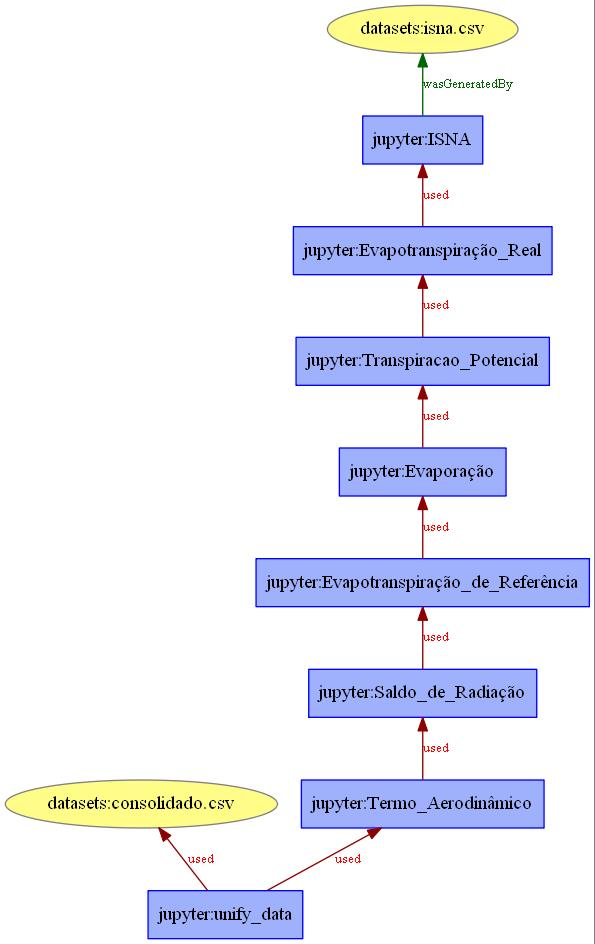

In [162]:
d1 = ProvDocument()

# Declaring namespaces for various prefixes used in the excution of Randon Walk Experiment
d1.add_namespace('inmet', 'datasets/consolidados.csv')
d1.add_namespace('foaf', 'http://xmlns.com/foaf/0.1/')
d1.add_namespace('datasets', 'datasets/')
d1.add_namespace('jupyter', 'KcDual-py.ipynb')
d1.add_namespace('local', 'zip')

# Adding an Agent 
#agent = 'foaf:AlexSantoss'
#d1.agent(agent)

# Adding an entity
entity = 'datasets:consolidado.csv'
e1 = d1.entity(entity)
 
entity = 'datasets:isna.csv'
e2 = d1.entity(entity)

#Generation
#a1 = 'local:conslidados'
#d1.activity(a1)

a2 = 'jupyter:unify_data'
d1.activity(a2)

a3 = 'jupyter:Termo_Aerodinâmico'
d1.activity(a3)

a4 = 'jupyter:Saldo_de_Radiação'
d1.activity(a4)

a5 = 'jupyter:Evapotranspiração_de_Referência'
d1.activity(a5)

a6 = 'jupyter:Transpiracao_Potencial'
d1.activity(a6)

a7 = 'jupyter:Evaporação'
d1.activity(a7)

a8 = 'jupyter:Transpiracao_Potencial'
d1.activity(a8)

a9 = 'jupyter:Evapotranspiração_Real'
d1.activity(a9)

a10 = 'jupyter:ISNA'
d1.activity(a10)


#Relations
#d1.used(a1, e1)
#d1.wasGeneratedBy(e1, a1)
d1.used(a2, e1)
d1.used(a2, a3) #Termo_Aerodinâmico
d1.used(a3, a4) #Saldo_de_Radiação
d1.used(a4, a5) #Evapotranspiração_de_referência
#d1.used(a5, a6) #Transpiracao_Potencial
d1.used(a5, a7) #Evaporação
d1.used(a7, a8) #Transpiracao_Potencial
d1.used(a8, a9) #Evapotranspiração_Real
d1.used(a9, a10) #ISNA

d1.wasGeneratedBy(a10, e2)

dot = prov_to_dot(d1)
graph = "dot.jpeg"
dot.write_jpeg(graph)
Image(graph)

# Dicinoário de Dados
COEFICIENTE_BASAL    => KCB\
COEFICIENTE_CULTURA  => KC\
COEFICIENTE_EVAPO    => KE\
EVAPO_CULTURA        => ETC\
TRANSP_POTENCIAL     => TRP\
EVAPO                => E\
ARMAZENAMENTO_AGUA   => ARM\
Capacidade de Campo  => TAR\
ARM2                 => ARM2\
EVAPO_REFERENCIA     => ET0\
EVAPO_REAL           => ETR\
TR                   => TR\
TA                   => TA\
DIAJULIANO           => DIAJULIANO\
TARMEDIO             => TAR/2 \
Indice de Satisfação => ISNA\
PLUVIOSIDADE         => P\


In [163]:
#Termo Aerodinâmico    
def termoAeroDinamico(params, urx, urn, tx, tn):
    tm   = (tx + tn)/2
    #Pressão de saturação do vapor d'água do ar - Equação de Tetens [kPa]
    es   = (0.6108* exp(17.27*tx/(237.3+tx))+ 0.6108* exp(17.27*tn/(237.3+tn)))/2
    #Pressão real do vapor d'água do ar [kPa]   
    ea   = (urn * 0.6108* exp(17.27*tx/(237.3+tx))+ urx * 0.6108* exp(17.27*tn/(237.3+tn)))/ 200
    #Declividade da curva de pressão de saturação [kPa/oC]
    S    = 4098 * 0.6108* exp(17.27*tm/(237.3+tm))/((237.3 + tm)**2)
    #Pressão atmosférica [kPa]
    Patm = 101.3*((293-0.0065*params.Z)/(293))**5.26
    #Calor latente de evaporação [MJ/kg]
    lamb = 0.665E-3*Patm
    
    return S, tm, es, ea, lamb

#Termo Radioativo
def saldoDeRadiacao(params, doy, qg, tx, tn, ea):
    #Radiação solar extraterrestre

    #Correção relativa Terra-Sol
    dr   = 1 + 0.033 * cos(2*pi/365*doy)
    #Declinação Solar 
    decl = 0.409 * sin((2*pi/365*doy)-1.39)
    #Angulo Horário
    ws   = acos(-tan(params.FI*pi/180)*tan(decl))
    #Radiação Solar Extraterrestre
    Qo   = 37.568*dr*((ws*sin(params.FI*pi/180)*sin(decl))+(cos(params.FI*pi/180)*cos(decl)*sin(ws)))

    #Balanço de radiação
    #Ondas curtas
    
    #Radiação solar para dia de céu sem nebulosidade
    Qso = (0.75 + 2E-5*params.Z)*Qo
    Qoc = 0.77 * qg
    
    #Ondas longas
    Qol    = 4.903E-9*((((tx + 273.16)**4)+ ((tn + 273.16)**4))/2)*(0.34-0.14*ea**0.5)*(1.35*(qg/Qso)-0.35)

    return Qoc - Qol

#Transpiração Potencial
def transpiracaoPotencial(params, u2, urn, aETo_PM, t):
    if t < params.L_INI:
        Kcb = params.KCB_INI
    elif t < params.L_INI + params.L_CRES:
        Kcb = params.KCB_INI+(t-params.L_INI)/params.L_CRES*(params.KCB_MID-params.KCB_INI)
    elif t < params.L_INI + params.L_CRES + params.L_MID:
        Kcb = params.KCB_MID
    else:
        Kcb = params.KCB_MID+(t-(params.L_INI+params.L_CRES+params.L_MID))/(params.L_FIM*(params.KCB_FIM-params.KCB_MID))
        
    trp = Kcb * aETo_PM
    h = max((Kcb/params.KCB_MID)*params.HX,params.H)
    kcx = max(1.2+(0.04*(u2-2)-0.004*(urn-45))*(h/3)**0.3,Kcb+0.05)

    return Kcb, trp, h, kcx

#Balanço de água no solo
def evaporacao(params, p, Kcb, kcx, ETo_PM, De_f, h, t):
    #Camada subsuperfícial - Evaporação
    fc = max(abs(((Kcb-params.KCB_INI)/(kcx-params.KCB_INI)))**(1 + 0.5*params.H),0.01)
    
    if p > 0: fw = 1
    else: fw = params.FW_INI
    
    few = min(1-fc,fw)
    TAE = 1000*(params.CC-0.5*params.PM)*params.ZE
    
    if t == 1: De_i = TAE - params.AFE
    else: De_i = max(De_f-p, 0)
        
    if De_i < params.AFE: kr = 1
    else: kr = max((TAE - De_i)/(TAE - params.AFE), 0)
            
    ke = min(kr*(kcx-Kcb), few*kcx)
    E = ke * ETo_PM
    
    if t == 1:
        Dp = max(p, 0)
        De_f = min(De_i - p+(E/few) + Dp, TAE)
    else:
        Dp = max(p-De_f, 0)
        De_f = min(De_f - p+(E/few) + Dp, TAE)
        
    Kc = Kcb + ke
    ETc = Kc * ETo_PM

    return ETc, ke, De_f, De_i


def evapotranspiracaoReal(params, ap, aKcb, aETc, aKe, aETo_PM, De_i, Dr_f, t):
    if t <= (params.L_INI + params.L_CRES + params.L_MID):
        Zr = ((aKcb - params.KCB_INI)/(params.KCB_MID - params.KCB_INI))*(params.ZRX - params.ZRN) + params.ZRN
    else:
        Zr = params.ZRN
    
    TAR = 1000.*(params.CC - params.PM)*Zr
    AFR = params.F*TAR
    
    if t == 1:
        Dr_i = min( max((TAR-AFR)-ap+aETc, 0), TAR)
        if Dr_i < AFR:
            ks = 1
        else:
            ks = max( (TAR-Dr_i)/(TAR-AFR), 0)

        Dp = max( ap-aETc-Dr_i, 0 )
        kcr = aKe + ks * aKcb
        ETR = kcr * aETo_PM
        Tr = ks * aKcb *aETo_PM
        Dr_f = max( min((TAR-AFR)-ap+ETR+Dp, TAR), 0 )
    else:
        Dr_i = min( max(Dr_f-ap+aETc, 0), TAR)
        if Dr_i < AFR:
            ks = 1
        else:
            ks = max( (TAR-Dr_i)/(TAR-AFR), 0)
        
        Dp = max( ap-aETc-Dr_f, 0)
        kcr = aKe + ks*aKcb
        ETR = kcr * aETo_PM
        Tr = ks*aKcb*aETo_PM
        Dr_f = min(Dr_f-ap+ETR+Dp, TAR)

    return  TAR, Dr_f, ETR

In [164]:
def main():
    todos = []
    for k, v in dados.groupby(level=[0, 1, 2, 3]):
        isnas = []       
        for i in range(9):
            De_f = De_i = Dr_f = 0
            isna_array = [0, 0, 0, 0, 0, 0]
            for idx, (_, (dia, _, _, _, ap, qg, tx, tn, urx, urn, u2)) in enumerate(v.iloc[i*20:111+i*20].iterrows()):
                if np.isnan(ap+qg+tx+tn+urx+urn+u2):
                    print(k, dia)
                    continue
                
                doy = datetime.datetime.strptime(dia, '%Y-%m-%d').timetuple().tm_yday

                S, tm, es, ea, lamb = termoAeroDinamico(params, urx, urn, tx, tn) #conferido
                #Saldo de Radiação
                Qn = saldoDeRadiacao(params, doy, qg, tx, tn, ea) #conferido
                #Evapotranspiração de referência [mm/d]
                aETo_PM = (0.408*S*(Qn)+lamb*900*u2*(es-ea)/(tm + 273))/(S+lamb*(1+0.34*u2)) #conferido
                #Transpiracao Potencial
                aKcb, trp, h, kcx = transpiracaoPotencial(params, u2, urn, aETo_PM, idx+1) #conferido
                #Evaporação
                aETc, aKe, De_f, De_i = evaporacao(params, ap, aKcb, kcx, aETo_PM, De_f, h, idx+1) #conferido
                aTAR, Dr_f, ETR = evapotranspiracaoReal(params, ap, aKcb, aETc, aKe, aETo_PM, De_i, Dr_f,idx+1)

                ISNA = ETR/aETc
                print(doy,dia,ISNA)
                if ISNA >= 0 and ISNA <= 0.25: isna_array[0] += 1
                elif ISNA <= 0.5: isna_array[1] += 1
                elif ISNA <= 0.75: isna_array[2] += 1
                elif ISNA <= 0.9: isna_array[3] += 1
                elif ISNA <= 1 : isna_array[4] += 1
                else:                     
                    print(ISNA,k,dia)
                    isna_array[5] += 1
            isnas.append(pd.Series(isna_array, name=f'{v.iloc[i*20]["Data"]} até {v.iloc[111+i*20]["Data"]}', index=['Risco Extremo', 'Risco Alto', 'Risco Baixo', 'Risco Muito Baixo', 'Sem Risco', 'Erro']))
            
            
        df = pd.concat(isnas, axis=1)
        df.name = k[3] #' '.join(k)
        todos.append(df)#.to_csv('datasets/isnas/'+'_'.join(k)+'.csv')
    return todos

In [165]:
#Precisa instalar xlrd ("pip install xlrd" ou "conda install xlrd")
dados = pd.read_csv("datasets/consolidado.csv", sep=';', index_col=[1, 2, 3, 4])
params = pd.read_excel("datasets/ParametrosSoja.xls").squeeze()
params.index = params.index.str.upper()

#pd.Series(isna_array, name=f'{v.iloc[i*20]["Data"]} até {v.iloc[120+i*20]["Data"]}', index=['Risco Extremo', 'Risco Alto', 'Risco Baixo', 'Risco Muito Baixo', 'Sem Risco', 'Erro'])

In [166]:
isnas = main()

1 2019-01-01 0.5832166573671465
2 2019-01-02 0.5798637024695399
3 2019-01-03 0.0
4 2019-01-04 0.1793917538042171
5 2019-01-05 0.5739304413044138
6 2019-01-06 0.0
7 2019-01-07 0.5691823725977917
8 2019-01-08 0.0663048634293525
9 2019-01-09 0.5893967291684911
10 2019-01-10 0.5879759148812719
11 2019-01-11 0.0
12 2019-01-12 0.5801895829911212
13 2019-01-13 0.0
14 2019-01-14 0.0
15 2019-01-15 0.0
16 2019-01-16 0.0
17 2019-01-17 0.0
18 2019-01-18 0.5924417933886964
19 2019-01-19 0.5613311882213913
20 2019-01-20 0.5700017581161033
21 2019-01-21 0.0
22 2019-01-22 0.0
23 2019-01-23 0.0
24 2019-01-24 0.0
25 2019-01-25 0.0
26 2019-01-26 0.0
27 2019-01-27 0.0
28 2019-01-28 0.04485644674284142
29 2019-01-29 0.0
30 2019-01-30 0.0
31 2019-01-31 0.0
32 2019-02-01 0.0
33 2019-02-02 0.0
34 2019-02-03 0.0
35 2019-02-04 0.0
36 2019-02-05 0.3393306649733139
37 2019-02-06 0.023447292733077607
38 2019-02-07 0.0
39 2019-02-08 0.0
40 2019-02-09 0.0
41 2019-02-10 0.24860131045874753
42 2019-02-11 0.0
43 2019-0

Risco Extremo        96
Risco Alto            4
Risco Baixo          10
Risco Muito Baixo     0
Sem Risco             1
Erro                  0
Name: 2019-01-01 até 2019-04-22, dtype: int64

21 2019-01-21 0.5850660271745435
22 2019-01-22 0.0
23 2019-01-23 0.0
24 2019-01-24 0.0
25 2019-01-25 0.0
26 2019-01-26 0.0
27 2019-01-27 0.0
28 2019-01-28 0.07006271221931581
29 2019-01-29 0.0
30 2019-01-30 0.0
31 2019-01-31 0.0
32 2019-02-01 0.0
33 2019-02-02 0.0
34 2019-02-03 0.0
35 2019-02-04 0.0
36 2019-02-05 0.5853068773040477
37 2019-02-06 0.06598016223169573
38 2019-02-07 0.0
39 2019-02-08 0.0
40 2019-02-09 0.0
41 2019-02-10 0.5630443673621233
42 2019-02-11 0.0
43 2019-02-12 0.5274256105692292
44 2019-02-13 0.4118917596320256
45 2019-02-14 0.0
46 2019-02-15 0.1610177330585767
47 2019-02-16 0.0
48 2019-02-17 0.26768411226164696
49 2019-02-18 0.07127632669316161
50 2019-02-19 0.3777759321810689
51 2019-02-20 0.0
52 2019-02-21 0.0
53 2019-02-22 0.0
54 2019-02-23 0.0
55 2019-02-24 0.11097082234766768
56 2019-02-25 0.0
57 2019-02-26 0.30385569023628467
58 2019-02-27 0.2323683390993141
59 2019-02-28 0.2647023958144656
60 2019-03-01 0.0
61 2019-03-02 0.0
62 2019-03-03 0.0
63 2019-03-04

Risco Extremo        99
Risco Alto            5
Risco Baixo           7
Risco Muito Baixo     0
Sem Risco             0
Erro                  0
Name: 2019-01-21 até 2019-05-12, dtype: int64

41 2019-02-10 0.5787439659820671
42 2019-02-11 0.0
43 2019-02-12 0.5750758787669057
44 2019-02-13 0.476805575593516
45 2019-02-14 0.0
46 2019-02-15 0.2183260267897479
47 2019-02-16 0.0
48 2019-02-17 0.37127681365188187
49 2019-02-18 0.11985464401794615
50 2019-02-19 0.5499119910778718
51 2019-02-20 0.0
52 2019-02-21 0.0
53 2019-02-22 0.0
54 2019-02-23 0.0
55 2019-02-24 0.23229629744876873
56 2019-02-25 0.0
57 2019-02-26 0.5746913753359183
58 2019-02-27 0.5466675970495685
59 2019-02-28 0.5711169007402036
60 2019-03-01 0.0
61 2019-03-02 0.0
62 2019-03-03 0.0
63 2019-03-04 0.0
64 2019-03-05 0.0
65 2019-03-06 0.4957482107244565
66 2019-03-07 0.1903714250615917
67 2019-03-08 0.0
68 2019-03-09 0.4482088920107315
69 2019-03-10 0.0
70 2019-03-11 0.0
71 2019-03-12 0.1723830624354984
72 2019-03-13 0.366174054409017
73 2019-03-14 0.366627548691534
74 2019-03-15 0.32348731161324906
75 2019-03-16 0.0905060020072195
76 2019-03-17 0.30889983259322223
77 2019-03-18 0.2776319242530742
78 2019-03-19 0.0

Risco Extremo        93
Risco Alto           10
Risco Baixo           8
Risco Muito Baixo     0
Sem Risco             0
Erro                  0
Name: 2019-02-10 até 2019-06-01, dtype: int64

61 2019-03-02 0.5919016818078989
62 2019-03-03 0.0
63 2019-03-04 0.0
64 2019-03-05 0.0
65 2019-03-06 0.5729310162499914
66 2019-03-07 0.25575594971164356
67 2019-03-08 0.0
68 2019-03-09 0.5752779698804945
69 2019-03-10 0.0
70 2019-03-11 0.0
71 2019-03-12 0.2939623835992261
72 2019-03-13 0.5639656603409992
73 2019-03-14 0.5740625315513896
74 2019-03-15 0.5584792198594746
75 2019-03-16 0.2314655105453633
76 2019-03-17 0.568787124462778
77 2019-03-18 0.5609753597933679
78 2019-03-19 0.24666036375833808
79 2019-03-20 0.546425836511511
80 2019-03-21 0.0
81 2019-03-22 0.511585454776793
82 2019-03-23 0.0
83 2019-03-24 0.0
84 2019-03-25 0.0
85 2019-03-26 0.0
86 2019-03-27 0.0
87 2019-03-28 0.0
88 2019-03-29 0.0
89 2019-03-30 0.0
90 2019-03-31 0.0
91 2019-04-01 0.0
92 2019-04-02 0.0
93 2019-04-03 0.3620430342662685
94 2019-04-04 0.027779805051400083
95 2019-04-05 0.3390035675964177
96 2019-04-06 0.1604891449597429
97 2019-04-07 0.020723836062077644
98 2019-04-08 0.021883995860234026
99 2019-04-

Risco Extremo        96
Risco Alto            5
Risco Baixo          10
Risco Muito Baixo     0
Sem Risco             0
Erro                  0
Name: 2019-03-02 até 2019-06-21, dtype: int64

81 2019-03-22 0.5824859495386339
82 2019-03-23 0.0
83 2019-03-24 0.0
84 2019-03-25 0.0
85 2019-03-26 0.0
86 2019-03-27 0.0
87 2019-03-28 0.0
88 2019-03-29 0.0
89 2019-03-30 0.0
90 2019-03-31 0.0
91 2019-04-01 0.0
92 2019-04-02 0.0
93 2019-04-03 0.5713330626972232
94 2019-04-04 0.0649826758535291
95 2019-04-05 0.5764965334110519
96 2019-04-06 0.3807010645110688
97 2019-04-07 0.06246731096270405
98 2019-04-08 0.06598993097510496
99 2019-04-09 0.0
100 2019-04-10 0.0
101 2019-04-11 0.0
102 2019-04-12 0.0
103 2019-04-13 0.09723425407790023
104 2019-04-14 0.04904646092432826
105 2019-04-15 0.0
106 2019-04-16 0.0
107 2019-04-17 0.0
108 2019-04-18 0.0
109 2019-04-19 0.0
110 2019-04-20 0.0
111 2019-04-21 0.035346799314281065
112 2019-04-22 0.37062591842915504
113 2019-04-23 0.0
114 2019-04-24 0.0
115 2019-04-25 0.0
116 2019-04-26 0.0
117 2019-04-27 0.06768874431928301
118 2019-04-28 0.0
119 2019-04-29 0.0
120 2019-04-30 0.0
121 2019-05-01 0.21632007310073703
122 2019-05-02 0.0
123 2019-05-03 0.

Risco Extremo        101
Risco Alto             4
Risco Baixo            5
Risco Muito Baixo      0
Sem Risco              1
Erro                   0
Name: 2019-03-22 até 2019-07-11, dtype: int64

101 2019-04-11 0.5865452335374062
102 2019-04-12 0.0
103 2019-04-13 0.11593377115387778
104 2019-04-14 0.06261984435064177
105 2019-04-15 0.0
106 2019-04-16 0.0
107 2019-04-17 0.0
108 2019-04-18 0.0
109 2019-04-19 0.0
110 2019-04-20 0.0
111 2019-04-21 0.06702669700119777
112 2019-04-22 0.5666948598742454
113 2019-04-23 0.0
114 2019-04-24 0.0
115 2019-04-25 0.0
116 2019-04-26 0.0
117 2019-04-27 0.17541377652031248
118 2019-04-28 0.0
119 2019-04-29 0.0
120 2019-04-30 0.0
121 2019-05-01 0.5472144777651646
122 2019-05-02 0.0
123 2019-05-03 0.5109001186612742
124 2019-05-04 0.0
125 2019-05-05 0.0
126 2019-05-06 0.0
127 2019-05-07 0.0
128 2019-05-08 0.0
129 2019-05-09 0.0
130 2019-05-10 0.2790576549016699
131 2019-05-11 0.0
132 2019-05-12 0.0
133 2019-05-13 0.11286647154781347
134 2019-05-14 0.0
135 2019-05-15 0.0
136 2019-05-16 0.0
137 2019-05-17 0.0
138 2019-05-18 0.0
139 2019-05-19 0.0
140 2019-05-20 0.0
141 2019-05-21 0.0
142 2019-05-22 0.0
143 2019-05-23 0.17928165654707598
144 2019-05-

Risco Extremo        104
Risco Alto             1
Risco Baixo            4
Risco Muito Baixo      0
Sem Risco              2
Erro                   0
Name: 2019-04-11 até 2019-07-31, dtype: int64

121 2019-05-01 0.5636567389281513
122 2019-05-02 0.0
123 2019-05-03 0.5607054082535095
124 2019-05-04 0.0
125 2019-05-05 0.0
126 2019-05-06 0.0
127 2019-05-07 0.0
128 2019-05-08 0.0
129 2019-05-09 0.0
130 2019-05-10 0.4169303542483664
131 2019-05-11 0.0
132 2019-05-12 0.0
133 2019-05-13 0.2389077833036026
134 2019-05-14 0.0
135 2019-05-15 0.0
136 2019-05-16 0.0
137 2019-05-17 0.0
138 2019-05-18 0.0
139 2019-05-19 0.0
140 2019-05-20 0.0
141 2019-05-21 0.0
142 2019-05-22 0.0
143 2019-05-23 0.5034585075213637
144 2019-05-24 0.2963780173526534
145 2019-05-25 0.0
146 2019-05-26 0.0
147 2019-05-27 0.0
148 2019-05-28 0.3918103540431515
149 2019-05-29 0.0367068717440891
150 2019-05-30 0.0
151 2019-05-31 0.0
152 2019-06-01 0.3829394861361806
153 2019-06-02 0.20362153745005582
154 2019-06-03 0.30726135044557623
155 2019-06-04 0.0
156 2019-06-05 0.0
157 2019-06-06 0.024913899769474442
158 2019-06-07 0.0
159 2019-06-08 0.0
160 2019-06-09 0.0
161 2019-06-10 0.0
162 2019-06-11 0.0
163 2019-06-12 0.0

Risco Extremo        100
Risco Alto             6
Risco Baixo            4
Risco Muito Baixo      0
Sem Risco              1
Erro                   0
Name: 2019-05-01 até 2019-08-20, dtype: int64

141 2019-05-21 0.5938689695555751
142 2019-05-22 0.0
143 2019-05-23 0.5527331361691932
144 2019-05-24 0.34808163899973343
145 2019-05-25 0.0
146 2019-05-26 0.0
147 2019-05-27 0.0
148 2019-05-28 0.5185053418618192
149 2019-05-29 0.06346034699460495
150 2019-05-30 0.0
151 2019-05-31 0.0
152 2019-06-01 0.5742655874665203
153 2019-06-02 0.38628700122974396
154 2019-06-03 0.5492418069596443
155 2019-06-04 0.0
156 2019-06-05 0.0
157 2019-06-06 0.06786904839144793
158 2019-06-07 0.0
159 2019-06-08 0.0
160 2019-06-09 0.0
161 2019-06-10 0.0
162 2019-06-11 0.0
163 2019-06-12 0.0
164 2019-06-13 0.0
165 2019-06-14 0.0
166 2019-06-15 0.0
167 2019-06-16 0.0
168 2019-06-17 0.0
169 2019-06-18 0.0
170 2019-06-19 0.0
171 2019-06-20 0.0
172 2019-06-21 0.0
173 2019-06-22 0.0
174 2019-06-23 0.0
175 2019-06-24 0.0
176 2019-06-25 0.0
177 2019-06-26 0.32192358721852177
178 2019-06-27 0.17090753366170866
179 2019-06-28 0.02332568812146577
180 2019-06-29 0.0
181 2019-06-30 0.0
182 2019-07-01 0.0
183 2019-07-02 

Risco Extremo        101
Risco Alto             4
Risco Baixo            5
Risco Muito Baixo      0
Sem Risco              1
Erro                   0
Name: 2019-05-21 até 2019-09-09, dtype: int64

161 2019-06-10 0.5911262686697467
162 2019-06-11 0.0
163 2019-06-12 0.0
164 2019-06-13 0.0
165 2019-06-14 0.0
166 2019-06-15 0.0
167 2019-06-16 0.0
168 2019-06-17 0.0
169 2019-06-18 0.0
170 2019-06-19 0.0
171 2019-06-20 0.0
172 2019-06-21 0.0
173 2019-06-22 0.0
174 2019-06-23 0.0
175 2019-06-24 0.0
176 2019-06-25 0.0
177 2019-06-26 0.5842256834651718
178 2019-06-27 0.46652928687459394
179 2019-06-28 0.06988110862359868
180 2019-06-29 0.0
181 2019-06-30 0.0
182 2019-07-01 0.0
183 2019-07-02 0.0
184 2019-07-03 0.5034107040357457
185 2019-07-04 1.0
186 2019-07-05 0.5373332911366384
187 2019-07-06 0.0
188 2019-07-07 0.0
189 2019-07-08 0.0
190 2019-07-09 0.0
191 2019-07-10 0.0
192 2019-07-11 0.0
193 2019-07-12 0.0
194 2019-07-13 0.0
195 2019-07-14 0.0
196 2019-07-15 0.15838498185207794
197 2019-07-16 0.07875967721531163
198 2019-07-17 0.0
199 2019-07-18 0.0
200 2019-07-19 0.0
201 2019-07-20 0.0
202 2019-07-21 0.0
203 2019-07-22 0.0
204 2019-07-23 0.0
205 2019-07-24 0.0
206 2019-07-25 0.0
20

Risco Extremo        103
Risco Alto             1
Risco Baixo            6
Risco Muito Baixo      0
Sem Risco              1
Erro                   0
Name: 2019-06-10 até 2019-09-29, dtype: int64

1 2019-01-01 0.5643166599516578
2 2019-01-02 0.20663174370489604
3 2019-01-03 0.1205567106040756
4 2019-01-04 0.5768376822692013
5 2019-01-05 1.0
6 2019-01-06 0.3771549272095953
7 2019-01-07 0.5652499021374485
8 2019-01-08 0.06366410139149502
9 2019-01-09 0.0
10 2019-01-10 0.0
11 2019-01-11 0.173622547244742
12 2019-01-12 0.5701259491389762
13 2019-01-13 0.0
14 2019-01-14 0.3237809005768845
15 2019-01-15 0.06392173599092356
16 2019-01-16 0.0
17 2019-01-17 0.0
18 2019-01-18 0.5801895829911213
19 2019-01-19 0.5653768527600186
20 2019-01-20 0.0
21 2019-01-21 0.0
22 2019-01-22 0.0
23 2019-01-23 0.0
24 2019-01-24 0.0
25 2019-01-25 0.0
26 2019-01-26 0.0
27 2019-01-27 0.0
28 2019-01-28 0.2370542471330173
29 2019-01-29 0.0
30 2019-01-30 0.0
31 2019-01-31 0.0
32 2019-02-01 0.0
33 2019-02-02 0.0
34 2019-02-03 0.0
35 2019-02-04 0.0
36 2019-02-05 0.0
37 2019-02-06 0.0
38 2019-02-07 0.0
39 2019-02-08 0.0
40 2019-02-09 0.0
41 2019-02-10 0.2329761548208642
42 2019-02-11 0.0
43 2019-02-12 0.2026664474

Risco Extremo        97
Risco Alto            5
Risco Baixo           6
Risco Muito Baixo     0
Sem Risco             3
Erro                  0
Name: 2019-01-01 até 2019-04-22, dtype: int64

21 2019-01-21 0.5744380328345035
22 2019-01-22 0.0
23 2019-01-23 0.0
24 2019-01-24 0.0
25 2019-01-25 0.0
26 2019-01-26 0.0
27 2019-01-27 0.0
28 2019-01-28 0.33588144301964035
29 2019-01-29 0.0
30 2019-01-30 0.0
31 2019-01-31 0.0
32 2019-02-01 0.0
33 2019-02-02 0.0
34 2019-02-03 0.0
35 2019-02-04 0.0
36 2019-02-05 0.0
37 2019-02-06 0.0
38 2019-02-07 0.0
39 2019-02-08 0.0
40 2019-02-09 0.0
41 2019-02-10 0.5553565818448506
42 2019-02-11 0.0
43 2019-02-12 0.5242575363428587
44 2019-02-13 0.0
45 2019-02-14 0.472900407473834
46 2019-02-15 0.08336844078896724
47 2019-02-16 0.04416864222933177
48 2019-02-17 0.14151006368602925
49 2019-02-18 0.44227426621122534
50 2019-02-19 0.4080767587849679
51 2019-02-20 0.03136859163970319
52 2019-02-21 0.33991138642503405
53 2019-02-22 0.0
54 2019-02-23 0.15400590647140244
55 2019-02-24 0.0
56 2019-02-25 0.0
57 2019-02-26 1.0
58 2019-02-27 0.21799446575165088
59 2019-02-28 0.1760001352332253
60 2019-03-01 0.0
61 2019-03-02 0.0
62 2019-03-03 0.0
63 2019-03-

Risco Extremo        96
Risco Alto            7
Risco Baixo           6
Risco Muito Baixo     0
Sem Risco             2
Erro                  0
Name: 2019-01-21 até 2019-05-12, dtype: int64

41 2019-02-10 0.5714153528053323
42 2019-02-11 0.0
43 2019-02-12 0.5723184631812984
44 2019-02-13 0.0
45 2019-02-14 0.556934894307954
46 2019-02-15 0.11807714505736897
47 2019-02-16 0.06641711356200379
48 2019-02-17 0.21491760281023847
49 2019-02-18 0.5821147454193105
50 2019-02-19 0.5697842510715054
51 2019-02-20 0.06229257464655315
52 2019-02-21 0.5244942973501333
53 2019-02-22 0.0
54 2019-02-23 0.30128727283909296
55 2019-02-24 0.0
56 2019-02-25 0.0
57 2019-02-26 1.0
58 2019-02-27 0.5395146493219903
59 2019-02-28 0.41678756039179504
60 2019-03-01 0.0
61 2019-03-02 0.0
62 2019-03-03 0.0
63 2019-03-04 0.0
64 2019-03-05 0.0
65 2019-03-06 0.0
66 2019-03-07 0.13136233760733795
67 2019-03-08 0.0
68 2019-03-09 0.11143101641905358
69 2019-03-10 0.0
70 2019-03-11 0.24253792917324637
71 2019-03-12 0.35961851887610435
72 2019-03-13 0.07556332253730043
73 2019-03-14 0.2727760925142391
74 2019-03-15 0.342166940346788
75 2019-03-16 0.038425514725242575
76 2019-03-17 0.26803337305932484
77 2019-03

Risco Extremo        91
Risco Alto            9
Risco Baixo           9
Risco Muito Baixo     1
Sem Risco             1
Erro                  0
Name: 2019-02-10 até 2019-06-01, dtype: int64

61 2019-03-02 0.5952494996380665
62 2019-03-03 0.0
63 2019-03-04 0.0
64 2019-03-05 0.0
65 2019-03-06 0.0
66 2019-03-07 0.17889377575397114
67 2019-03-08 0.0
68 2019-03-09 0.17180623795530228
69 2019-03-10 0.0
70 2019-03-11 0.3871188411076111
71 2019-03-12 0.5493782772284836
72 2019-03-13 0.15799661243508342
73 2019-03-14 0.466529275076333
74 2019-03-15 0.5691823725977917
75 2019-03-16 0.1076877006007319
76 2019-03-17 0.5469091000023159
77 2019-03-18 0.5579109360120289
78 2019-03-19 0.555379727533526
79 2019-03-20 0.536238511899831
80 2019-03-21 0.0
81 2019-03-22 0.0
82 2019-03-23 0.0
83 2019-03-24 0.0
84 2019-03-25 0.0
85 2019-03-26 0.0
86 2019-03-27 0.0
87 2019-03-28 0.0
88 2019-03-29 0.0
89 2019-03-30 0.0
90 2019-03-31 0.0
91 2019-04-01 0.0
92 2019-04-02 0.3717718122907438
93 2019-04-03 0.0
94 2019-04-04 0.0
95 2019-04-05 0.3387881941843825
96 2019-04-06 0.25730821912764884
97 2019-04-07 0.0
98 2019-04-08 0.019358332535137246
99 2019-04-09 0.019158826839504418
100 2019-04-10 0.0
101 

Risco Extremo        99
Risco Alto            5
Risco Baixo           7
Risco Muito Baixo     0
Sem Risco             0
Erro                  0
Name: 2019-03-02 até 2019-06-21, dtype: int64

81 2019-03-22 0.5765366971180051
82 2019-03-23 0.0
83 2019-03-24 0.0
84 2019-03-25 0.0
85 2019-03-26 0.0
86 2019-03-27 0.0
87 2019-03-28 0.0
88 2019-03-29 0.0
89 2019-03-30 0.0
90 2019-03-31 0.0
91 2019-04-01 0.0
92 2019-04-02 0.5673980264004534
93 2019-04-03 0.0
94 2019-04-04 0.0
95 2019-04-05 0.5763759965648837
96 2019-04-06 0.5337433453227952
97 2019-04-07 0.0
98 2019-04-08 0.06269117357679091
99 2019-04-09 0.06438022002284033
100 2019-04-10 0.0
101 2019-04-11 0.0
102 2019-04-12 0.0
103 2019-04-13 0.0
104 2019-04-14 0.0
105 2019-04-15 0.0
106 2019-04-16 0.0
107 2019-04-17 0.0
108 2019-04-18 0.0
109 2019-04-19 0.0
110 2019-04-20 0.0
111 2019-04-21 0.055569913753556625
112 2019-04-22 0.34006564595159755
113 2019-04-23 0.0
114 2019-04-24 0.0
115 2019-04-25 0.0
116 2019-04-26 0.0
117 2019-04-27 0.10782581918468614
118 2019-04-28 0.0498350178199022
119 2019-04-29 0.0
120 2019-04-30 0.20063554746610984
121 2019-05-01 0.19365885784229128
122 2019-05-02 0.0
123 2019-05-03 0.1381925516863613

Risco Extremo        104
Risco Alto             1
Risco Baixo            6
Risco Muito Baixo      0
Sem Risco              0
Erro                   0
Name: 2019-03-22 até 2019-07-11, dtype: int64

101 2019-04-11 0.5834985125052824
102 2019-04-12 0.0
103 2019-04-13 0.0
104 2019-04-14 0.0
105 2019-04-15 0.0
106 2019-04-16 0.0
107 2019-04-17 0.0
108 2019-04-18 0.0
109 2019-04-19 0.0
110 2019-04-20 0.0
111 2019-04-21 0.11136809498916941
112 2019-04-22 0.5480441567849761
113 2019-04-23 0.0
114 2019-04-24 0.0
115 2019-04-25 0.0
116 2019-04-26 0.0
117 2019-04-27 0.2811755131524615
118 2019-04-28 0.1603419518203204
119 2019-04-29 0.0
120 2019-04-30 0.5007726528704671
121 2019-05-01 0.536223562466034
122 2019-05-02 0.0
123 2019-05-03 0.4917975072731496
124 2019-05-04 0.0
125 2019-05-05 0.04585307999867488
126 2019-05-06 0.42575499229830116
127 2019-05-07 0.0
128 2019-05-08 0.0
129 2019-05-09 0.0
130 2019-05-10 0.0
131 2019-05-11 0.0
132 2019-05-12 0.04912233118816609
133 2019-05-13 0.0
134 2019-05-14 0.0
135 2019-05-15 0.025107620878743773
136 2019-05-16 0.0
137 2019-05-17 0.0
138 2019-05-18 0.0
139 2019-05-19 0.0
140 2019-05-20 0.0
141 2019-05-21 0.0
142 2019-05-22 0.0
143 2019-05-23 0.

Risco Extremo        103
Risco Alto             4
Risco Baixo            4
Risco Muito Baixo      0
Sem Risco              0
Erro                   0
Name: 2019-04-11 até 2019-07-31, dtype: int64

121 2019-05-01 0.5531885334594384
122 2019-05-02 0.0
123 2019-05-03 0.5441336387016965
124 2019-05-04 0.0
125 2019-05-05 0.06231226650155797
126 2019-05-06 0.5241668316502359
127 2019-05-07 0.0
128 2019-05-08 0.0
129 2019-05-09 0.0
130 2019-05-10 0.0
131 2019-05-11 0.0
132 2019-05-12 0.10828021372113188
133 2019-05-13 0.0
134 2019-05-14 0.0
135 2019-05-15 0.06385795396450779
136 2019-05-16 0.0
137 2019-05-17 0.0
138 2019-05-18 0.0
139 2019-05-19 0.0
140 2019-05-20 0.0
141 2019-05-21 0.0
142 2019-05-22 0.0
143 2019-05-23 0.27871902732067466
144 2019-05-24 0.3714128436657536
145 2019-05-25 0.044920175568305354
146 2019-05-26 0.0
147 2019-05-27 0.0
148 2019-05-28 0.13681383723338145
149 2019-05-29 0.17797869617985063
150 2019-05-30 0.0
151 2019-05-31 0.4122747134970347
152 2019-06-01 0.2582404567524106
153 2019-06-02 0.30913329414360363
154 2019-06-03 0.21745259805746145
155 2019-06-04 0.024701552964177673
156 2019-06-05 0.0
157 2019-06-06 0.0
158 2019-06-07 0.0
159 2019-06-08 0.0
160 201

Risco Extremo        100
Risco Alto             7
Risco Baixo            4
Risco Muito Baixo      0
Sem Risco              0
Erro                   0
Name: 2019-05-01 até 2019-08-20, dtype: int64

141 2019-05-21 0.5922277823574063
142 2019-05-22 0.0
143 2019-05-23 0.32282973541226256
144 2019-05-24 0.43206402399501737
145 2019-05-25 0.061297059319033426
146 2019-05-26 0.0
147 2019-05-27 0.0
148 2019-05-28 0.21020314822738756
149 2019-05-29 0.281470476939229
150 2019-05-30 0.0
151 2019-05-31 0.5828077763986421
152 2019-06-01 0.4543150162939175
153 2019-06-02 0.5401548589903099
154 2019-06-03 0.41713015525880776
155 2019-06-04 0.0633473846743099
156 2019-06-05 0.0
157 2019-06-06 0.0
158 2019-06-07 0.0
159 2019-06-08 0.0
160 2019-06-09 0.0
161 2019-06-10 0.0
162 2019-06-11 0.0
163 2019-06-12 0.0
164 2019-06-13 0.0
165 2019-06-14 0.0
166 2019-06-15 0.0
167 2019-06-16 0.0
168 2019-06-17 0.0
169 2019-06-18 0.0
170 2019-06-19 0.0
171 2019-06-20 0.0
172 2019-06-21 0.0
173 2019-06-22 0.0
174 2019-06-23 0.0
175 2019-06-24 0.0
176 2019-06-25 0.0
177 2019-06-26 0.1462611418253048
178 2019-06-27 0.08916213394537861
179 2019-06-28 0.0
180 2019-06-29 0.0
181 2019-06-30 0.0
182 2019-07-01 0.0
1

Risco Extremo        102
Risco Alto             6
Risco Baixo            3
Risco Muito Baixo      0
Sem Risco              0
Erro                   0
Name: 2019-05-21 até 2019-09-09, dtype: int64

161 2019-06-10 0.5893211998224714
162 2019-06-11 0.0
163 2019-06-12 0.0
164 2019-06-13 0.0
165 2019-06-14 0.0
166 2019-06-15 0.0
167 2019-06-16 0.0
168 2019-06-17 0.0
169 2019-06-18 0.0
170 2019-06-19 0.0
171 2019-06-20 0.0
172 2019-06-21 0.0
173 2019-06-22 0.0
174 2019-06-23 0.0
175 2019-06-24 0.0
176 2019-06-25 0.0
177 2019-06-26 0.3489074799290795
178 2019-06-27 0.2710809416345647
179 2019-06-28 0.0
180 2019-06-29 0.0
181 2019-06-30 0.0
182 2019-07-01 0.0
183 2019-07-02 0.04777276414435438
184 2019-07-03 0.5065856748007952
185 2019-07-04 0.43232015920469513
186 2019-07-05 0.0
187 2019-07-06 0.0
188 2019-07-07 0.0
189 2019-07-08 0.0
190 2019-07-09 0.0
191 2019-07-10 0.0
192 2019-07-11 0.0
193 2019-07-12 0.0
194 2019-07-13 0.0
195 2019-07-14 0.0
196 2019-07-15 0.35775525830785143
197 2019-07-16 0.0
198 2019-07-17 0.0
199 2019-07-18 0.0
200 2019-07-19 0.0
201 2019-07-20 0.0
202 2019-07-21 0.0
203 2019-07-22 0.0
204 2019-07-23 0.0
205 2019-07-24 0.0
206 2019-07-25 0.0
207 2019-07-26 0.0

Risco Extremo        104
Risco Alto             4
Risco Baixo            3
Risco Muito Baixo      0
Sem Risco              0
Erro                   0
Name: 2019-06-10 até 2019-09-29, dtype: int64

1 2019-01-01 0.5686621585473812
2 2019-01-02 0.5788730889589485
3 2019-01-03 0.0
4 2019-01-04 0.0
5 2019-01-05 0.5509982110788079
6 2019-01-06 0.578952509915382
7 2019-01-07 0.5771282281540719
8 2019-01-08 0.16571326995510344
9 2019-01-09 0.5574826576853684
10 2019-01-10 0.2589365495939288
11 2019-01-11 0.3269026815568414
12 2019-01-12 0.5727481527292027
13 2019-01-13 0.3768322171320609
14 2019-01-14 0.24653324315266453
15 2019-01-15 0.06289772112270837
16 2019-01-16 0.0
17 2019-01-17 0.0
18 2019-01-18 0.5738491142698285
19 2019-01-19 0.0
20 2019-01-20 0.0
21 2019-01-21 0.0
22 2019-01-22 0.0
23 2019-01-23 0.0
24 2019-01-24 0.0
25 2019-01-25 0.0
26 2019-01-26 0.4882060606562152
27 2019-01-27 0.043306336983023094
28 2019-01-28 0.21940755587641525
29 2019-01-29 0.0
30 2019-01-30 0.0
31 2019-01-31 0.0
32 2019-02-01 0.0
33 2019-02-02 0.031717416191422515
34 2019-02-03 0.0
35 2019-02-04 0.0
36 2019-02-05 0.0
37 2019-02-06 0.0
38 2019-02-07 0.0
39 2019-02-08 0.18952857925072145
40 2019-02-09 

Risco Extremo        93
Risco Alto            7
Risco Baixo           9
Risco Muito Baixo     0
Sem Risco             2
Erro                  0
Name: 2019-01-01 até 2019-04-22, dtype: int64

21 2019-01-21 0.5727890305169366
22 2019-01-22 0.0
23 2019-01-23 0.0
24 2019-01-24 0.0
25 2019-01-25 0.0
26 2019-01-26 0.5815861079400682
27 2019-01-27 0.06544990149074037
28 2019-01-28 0.31091897423425685
29 2019-01-29 0.0
30 2019-01-30 0.0
31 2019-01-31 0.0
32 2019-02-01 0.0
33 2019-02-02 0.06752352758174691
34 2019-02-03 0.0
35 2019-02-04 0.0
36 2019-02-05 0.0
37 2019-02-06 0.0
38 2019-02-07 0.0
39 2019-02-08 0.43962016398855336
40 2019-02-09 0.0
41 2019-02-10 0.5541013612811628
42 2019-02-11 0.0
43 2019-02-12 0.5124005981058811
44 2019-02-13 0.050242018293727556
45 2019-02-14 0.4760979308396153
46 2019-02-15 0.449119303507967
47 2019-02-16 0.0
48 2019-02-17 0.044635009381805896
49 2019-02-18 0.449467112428559
50 2019-02-19 0.4124939276340968
51 2019-02-20 0.03240075849933304
52 2019-02-21 0.0
53 2019-02-22 0.0
54 2019-02-23 0.0
55 2019-02-24 0.0
56 2019-02-25 0.0
57 2019-02-26 1.0
58 2019-02-27 0.191603306914798
59 2019-02-28 0.1456922476998687
60 2019-03-01 0.0
61 2019-03-02 0.0
6

Risco Extremo        95
Risco Alto            7
Risco Baixo           7
Risco Muito Baixo     0
Sem Risco             2
Erro                  0
Name: 2019-01-21 até 2019-05-12, dtype: int64

41 2019-02-10 0.5702190453388645
42 2019-02-11 0.0
43 2019-02-12 0.5620088978310166
44 2019-02-13 0.06389965858074463
45 2019-02-14 0.5594810742262291
46 2019-02-15 0.5457013077881666
47 2019-02-16 0.0
48 2019-02-17 0.06981086954981473
49 2019-02-18 0.5870614219710221
50 2019-02-19 0.5726970444924037
51 2019-02-20 0.06352172813270215
52 2019-02-21 0.0
53 2019-02-22 0.0
54 2019-02-23 0.0
55 2019-02-24 0.0
56 2019-02-25 0.0
57 2019-02-26 1.0
58 2019-02-27 0.5264886306171064
59 2019-02-28 0.39470009065103717
60 2019-03-01 0.0
61 2019-03-02 0.0
62 2019-03-03 0.0
63 2019-03-04 0.0
64 2019-03-05 0.0
65 2019-03-06 0.40153011893445645
66 2019-03-07 0.0
67 2019-03-08 0.0
68 2019-03-09 0.0
69 2019-03-10 0.0
70 2019-03-11 0.0
71 2019-03-12 0.3619583632494563
72 2019-03-13 0.3478472595134267
73 2019-03-14 0.029270958187546527
74 2019-03-15 0.32318134165415385
75 2019-03-16 0.020419297012544767
76 2019-03-17 0.041843504806216035
77 2019-03-18 0.25881979184604365
78 2019-03-19 0.25239684465328044
79

Risco Extremo        92
Risco Alto            7
Risco Baixo          10
Risco Muito Baixo     0
Sem Risco             2
Erro                  0
Name: 2019-02-10 até 2019-06-01, dtype: int64

61 2019-03-02 0.5946800200732718
62 2019-03-03 0.0
63 2019-03-04 0.0
64 2019-03-05 0.0
65 2019-03-06 0.4780608112292707
66 2019-03-07 0.0
67 2019-03-08 0.0
68 2019-03-09 0.0
69 2019-03-10 0.0
70 2019-03-11 0.0
71 2019-03-12 0.5508514258016511
72 2019-03-13 0.5527745780476534
73 2019-03-14 0.06453213164858781
74 2019-03-15 0.5583045189622954
75 2019-03-16 0.05795507341009613
76 2019-03-17 0.11542149033498306
77 2019-03-18 0.5512238473355437
78 2019-03-19 0.5567039635723444
79 2019-03-20 0.5372238393007676
80 2019-03-21 0.0
81 2019-03-22 0.0
82 2019-03-23 0.0
83 2019-03-24 0.0
84 2019-03-25 0.0
85 2019-03-26 0.0
86 2019-03-27 0.0
87 2019-03-28 0.0
88 2019-03-29 0.0
89 2019-03-30 0.0
90 2019-03-31 0.0
91 2019-04-01 0.0
92 2019-04-02 0.056769006549159964
93 2019-04-03 0.0
94 2019-04-04 0.0
95 2019-04-05 0.32806017767632234
96 2019-04-06 0.2523835980264504
97 2019-04-07 0.0
98 2019-04-08 0.0
99 2019-04-09 0.019831095530161442
100 2019-04-10 0.0
101 2019-04-11 0.017704298527772888
102 2019-0

Risco Extremo        99
Risco Alto            4
Risco Baixo           7
Risco Muito Baixo     0
Sem Risco             1
Erro                  0
Name: 2019-03-02 até 2019-06-21, dtype: int64

81 2019-03-22 0.5682659548696664
82 2019-03-23 0.0
83 2019-03-24 0.0
84 2019-03-25 0.0
85 2019-03-26 0.0
86 2019-03-27 0.0
87 2019-03-28 0.0
88 2019-03-29 0.0
89 2019-03-30 0.0
90 2019-03-31 0.0
91 2019-04-01 0.0
92 2019-04-02 0.11696965205228066
93 2019-04-03 0.0
94 2019-04-04 0.0
95 2019-04-05 0.5703844501696131
96 2019-04-06 0.5386225061913192
97 2019-04-07 0.0
98 2019-04-08 0.0
99 2019-04-09 0.06526893755418116
100 2019-04-10 0.0
101 2019-04-11 0.062432053751538104
102 2019-04-12 0.0
103 2019-04-13 0.05456981684114056
104 2019-04-14 0.16783887332939518
105 2019-04-15 0.0
106 2019-04-16 0.0
107 2019-04-17 0.0
108 2019-04-18 0.0
109 2019-04-19 0.0
110 2019-04-20 0.0
111 2019-04-21 0.18607445041652584
112 2019-04-22 0.3645014272549172
113 2019-04-23 0.027256623873882335
114 2019-04-24 0.0
115 2019-04-25 0.0
116 2019-04-26 0.0
117 2019-04-27 0.0
118 2019-04-28 0.23944463471615146
119 2019-04-29 0.0
120 2019-04-30 0.2786996447143942
121 2019-05-01 0.19518769427555738
122 2019-05-02 0.0


Risco Extremo        100
Risco Alto             4
Risco Baixo            6
Risco Muito Baixo      0
Sem Risco              1
Erro                   0
Name: 2019-03-22 até 2019-07-11, dtype: int64

101 2019-04-11 0.586468651401308
102 2019-04-12 0.0
103 2019-04-13 0.06518576846216831
104 2019-04-14 0.20768757271489047
105 2019-04-15 0.0
106 2019-04-16 0.0
107 2019-04-17 0.0
108 2019-04-18 0.0
109 2019-04-19 0.0
110 2019-04-20 0.0
111 2019-04-21 0.3066092955139459
112 2019-04-22 0.5629413473114369
113 2019-04-23 0.06206605885360478
114 2019-04-24 0.0
115 2019-04-25 0.0
116 2019-04-26 0.0
117 2019-04-27 0.0
118 2019-04-28 0.5074022649597008
119 2019-04-29 0.0
120 2019-04-30 0.5857108766882907
121 2019-05-01 0.5369619425241423
122 2019-05-02 0.0
123 2019-05-03 0.49616450885993496
124 2019-05-04 0.09501996186178595
125 2019-05-05 0.0
126 2019-05-06 0.0
127 2019-05-07 0.0
128 2019-05-08 0.0
129 2019-05-09 0.0
130 2019-05-10 0.0
131 2019-05-11 0.0
132 2019-05-12 0.0
133 2019-05-13 0.0
134 2019-05-14 0.0
135 2019-05-15 0.0
136 2019-05-16 0.0
137 2019-05-17 0.0
138 2019-05-18 0.0
139 2019-05-19 0.0
140 2019-05-20 0.0
141 2019-05-21 0.0
142 2019-05-22 0.0
143 2019-05-23 0.1214081982456013

Risco Extremo        101
Risco Alto             4
Risco Baixo            5
Risco Muito Baixo      0
Sem Risco              1
Erro                   0
Name: 2019-04-11 até 2019-07-31, dtype: int64

121 2019-05-01 0.5538916159668252
122 2019-05-02 0.0
123 2019-05-03 0.5479183202801832
124 2019-05-04 0.11943807536517285
125 2019-05-05 0.0
126 2019-05-06 0.0
127 2019-05-07 0.0
128 2019-05-08 0.0
129 2019-05-09 0.0
130 2019-05-10 0.0
131 2019-05-11 0.0
132 2019-05-12 0.0
133 2019-05-13 0.0
134 2019-05-14 0.0
135 2019-05-15 0.0
136 2019-05-16 0.0
137 2019-05-17 0.0
138 2019-05-18 0.0
139 2019-05-19 0.0
140 2019-05-20 0.0
141 2019-05-21 0.0
142 2019-05-22 0.0
143 2019-05-23 0.4834713424102878
144 2019-05-24 0.054331331773011665
145 2019-05-25 0.0
146 2019-05-26 0.045635016646025824
147 2019-05-27 0.0
148 2019-05-28 0.04003410536885354
149 2019-05-29 0.32240326275461123
150 2019-05-30 0.0
151 2019-05-31 0.0
152 2019-06-01 0.343125946584413
153 2019-06-02 0.061590978426790316
154 2019-06-03 0.3227027091300985
155 2019-06-04 0.02344607260290195
156 2019-06-05 0.0
157 2019-06-06 0.0
158 2019-06-07 0.0
159 2019-06-08 0.0
160 2019-06-09 0.0
161 2019-06-10 0.0
162 2019-06-11 0.0
163 2019-06-1

Risco Extremo        103
Risco Alto             5
Risco Baixo            2
Risco Muito Baixo      0
Sem Risco              1
Erro                   0
Name: 2019-05-01 até 2019-08-20, dtype: int64

141 2019-05-21 0.58615244998249
142 2019-05-22 0.0
143 2019-05-23 0.5369238785563283
144 2019-05-24 0.06827507282337507
145 2019-05-25 0.0
146 2019-05-26 0.06510503136505787
147 2019-05-27 0.0
148 2019-05-28 0.06457377621929604
149 2019-05-29 0.4614794726133661
150 2019-05-30 0.0
151 2019-05-31 0.0
152 2019-06-01 0.5385712430347835
153 2019-06-02 0.14838531147692482
154 2019-06-03 0.5580312718666777
155 2019-06-04 0.06176797467350462
156 2019-06-05 0.0
157 2019-06-06 0.0
158 2019-06-07 0.0
159 2019-06-08 0.0
160 2019-06-09 0.0
161 2019-06-10 0.0
162 2019-06-11 0.0
163 2019-06-12 0.0
164 2019-06-13 0.0
165 2019-06-14 0.0
166 2019-06-15 0.0
167 2019-06-16 0.0
168 2019-06-17 0.0
169 2019-06-18 0.0
170 2019-06-19 0.0
171 2019-06-20 0.0
172 2019-06-21 0.0
173 2019-06-22 0.0
174 2019-06-23 0.0
175 2019-06-24 0.0
176 2019-06-25 0.0
177 2019-06-26 0.2944261110399462
178 2019-06-27 0.20107917969740055
179 2019-06-28 0.0
180 2019-06-29 0.0
181 2019-06-30 0.0
182 2019-07-01 0.0
183 2019-07-02 0.0

Risco Extremo        102
Risco Alto             3
Risco Baixo            5
Risco Muito Baixo      0
Sem Risco              1
Erro                   0
Name: 2019-05-21 até 2019-09-09, dtype: int64

161 2019-06-10 0.5812133013166477
162 2019-06-11 0.0
163 2019-06-12 0.0
164 2019-06-13 0.0
165 2019-06-14 0.0
166 2019-06-15 0.0
167 2019-06-16 0.0
168 2019-06-17 0.0
169 2019-06-18 0.0
170 2019-06-19 0.0
171 2019-06-20 0.0
172 2019-06-21 0.0
173 2019-06-22 0.0
174 2019-06-23 0.0
175 2019-06-24 0.0
176 2019-06-25 0.0
177 2019-06-26 0.5697427962075203
178 2019-06-27 0.5311498206977127
179 2019-06-28 0.0
180 2019-06-29 0.0
181 2019-06-30 0.0
182 2019-07-01 0.0
183 2019-07-02 0.0
184 2019-07-03 0.5270868419808795
185 2019-07-04 1.0
186 2019-07-05 0.5181874202395961
187 2019-07-06 0.0
188 2019-07-07 0.0
189 2019-07-08 0.0
190 2019-07-09 0.0
191 2019-07-10 0.0
192 2019-07-11 0.0
193 2019-07-12 0.0
194 2019-07-13 0.0
195 2019-07-14 0.0
196 2019-07-15 0.3161351111293374
197 2019-07-16 0.25216928524301807
198 2019-07-17 0.0
199 2019-07-18 0.0
200 2019-07-19 0.0
201 2019-07-20 0.0
202 2019-07-21 0.0
203 2019-07-22 0.0
204 2019-07-23 0.0
205 2019-07-24 0.0
206 2019-07-25 0.0
207 2019-07-26 0.0
2

Risco Extremo        101
Risco Alto             3
Risco Baixo            6
Risco Muito Baixo      0
Sem Risco              1
Erro                   0
Name: 2019-06-10 até 2019-09-29, dtype: int64

1 2019-01-01 0.581134731042949
2 2019-01-02 0.22139284195043127
3 2019-01-03 0.0
4 2019-01-04 0.0
5 2019-01-05 0.4416627422598346
6 2019-01-06 0.0
7 2019-01-07 0.6094030613039587
8 2019-01-08 0.5866696190304139
9 2019-01-09 0.0
10 2019-01-10 0.0
11 2019-01-11 0.0
12 2019-01-12 0.6019427623674819
13 2019-01-13 0.0
14 2019-01-14 0.5987773133973251
15 2019-01-15 0.0
16 2019-01-16 0.0
17 2019-01-17 0.2706329461064039
18 2019-01-18 0.2656020986832381
19 2019-01-19 0.06652933670816416
20 2019-01-20 0.0
21 2019-01-21 0.0
22 2019-01-22 0.0
23 2019-01-23 0.0
24 2019-01-24 0.5366624808732061
25 2019-01-25 0.0
26 2019-01-26 0.5105374189966119
27 2019-01-27 0.4853438952590425
28 2019-01-28 0.04488624777933618
29 2019-01-29 0.3299567344729892
30 2019-01-30 0.0
31 2019-01-31 0.0
32 2019-02-01 0.0
33 2019-02-02 0.0
34 2019-02-03 0.0
35 2019-02-04 0.393722006355838
36 2019-02-05 0.0
37 2019-02-06 0.024968693760160813
38 2019-02-07 0.0
39 2019-02-08 0.3323220405317288
40 2019-02-09 0.0
41 2019-02-10 0.

Risco Extremo        95
Risco Alto            9
Risco Baixo           7
Risco Muito Baixo     0
Sem Risco             0
Erro                  0
Name: 2019-01-01 até 2019-04-22, dtype: int64

21 2019-01-21 0.6024654875502191
22 2019-01-22 0.0
23 2019-01-23 0.0
24 2019-01-24 0.5960733218361128
25 2019-01-25 0.0
26 2019-01-26 0.5988133623773013
27 2019-01-27 0.5881701943363563
28 2019-01-28 0.07009660370319727
29 2019-01-29 0.45505173330972865
30 2019-01-30 0.0
31 2019-01-31 0.0
32 2019-02-01 0.0
33 2019-02-02 0.0
34 2019-02-03 0.0
35 2019-02-04 0.6074457295732595
36 2019-02-05 0.0
37 2019-02-06 0.06793958101609535
38 2019-02-07 0.0
39 2019-02-08 0.6050237193408763
40 2019-02-09 0.0
41 2019-02-10 0.5795486614649413
42 2019-02-11 0.1595416594620997
43 2019-02-12 0.5283065126027419
44 2019-02-13 0.5180059271996634
45 2019-02-14 0.09510707176259582
46 2019-02-15 0.4770376627016445
47 2019-02-16 0.0
48 2019-02-17 0.0
49 2019-02-18 0.0
50 2019-02-19 0.4178665065648772
51 2019-02-20 0.4182391563933775
52 2019-02-21 0.0
53 2019-02-22 0.0
54 2019-02-23 0.3888303588984852
55 2019-02-24 0.0
56 2019-02-25 0.0
57 2019-02-26 0.820553377353742
58 2019-02-27 0.2557493598077923
59 2019-02-28

Risco Extremo        90
Risco Alto            8
Risco Baixo          11
Risco Muito Baixo     1
Sem Risco             0
Erro                  0
Name: 2019-01-21 até 2019-05-12, dtype: int64

41 2019-02-10 0.5944867683457156
42 2019-02-11 0.17692994275707905
43 2019-02-12 0.5758428037140719
44 2019-02-13 0.5804755457892391
45 2019-02-14 0.12513583854853785
46 2019-02-15 0.5730035106363917
47 2019-02-16 0.0
48 2019-02-17 0.0
49 2019-02-18 0.0
50 2019-02-19 0.5762453375286717
51 2019-02-20 0.5866313545430301
52 2019-02-21 0.0
53 2019-02-22 0.0
54 2019-02-23 0.5962468113189295
55 2019-02-24 0.0
56 2019-02-25 0.0
57 2019-02-26 1.0
58 2019-02-27 0.5583918866888749
59 2019-02-28 0.5709005206671514
60 2019-03-01 0.0
61 2019-03-02 0.0
62 2019-03-03 0.0
63 2019-03-04 0.0
64 2019-03-05 0.05405632075314844
65 2019-03-06 0.0
66 2019-03-07 0.08831460377368384
67 2019-03-08 0.45832490023873246
68 2019-03-09 0.0
69 2019-03-10 0.03847194320102625
70 2019-03-11 0.10606270762762368
71 2019-03-12 0.4248716616619234
72 2019-03-13 0.38198273348060674
73 2019-03-14 0.36419757695926874
74 2019-03-15 0.1252720647688974
75 2019-03-16 0.0
76 2019-03-17 0.3387306719705318
77 2019-03-18 0.290806331326

Risco Extremo        91
Risco Alto            7
Risco Baixo           9
Risco Muito Baixo     2
Sem Risco             1
Erro                  0
Name: 2019-02-10 até 2019-06-01, dtype: int64

61 2019-03-02 0.5827687935090525
62 2019-03-03 0.0
63 2019-03-04 0.0
64 2019-03-05 0.06798092276466257
65 2019-03-06 0.0
66 2019-03-07 0.12334520654965354
67 2019-03-08 0.5615212539143103
68 2019-03-09 0.0
69 2019-03-10 0.06550124335837887
70 2019-03-11 0.17875785864761864
71 2019-03-12 0.5908921327219879
72 2019-03-13 0.5736761911938286
73 2019-03-14 0.572615245876032
74 2019-03-15 0.27491601492666257
75 2019-03-16 0.0
76 2019-03-17 0.5849792526265676
77 2019-03-18 0.5678481112721528
78 2019-03-19 0.0
79 2019-03-20 0.20730779816533057
80 2019-03-21 0.3314966526950729
81 2019-03-22 0.0
82 2019-03-23 0.0
83 2019-03-24 0.0
84 2019-03-25 0.0
85 2019-03-26 0.0
86 2019-03-27 0.0
87 2019-03-28 0.0
88 2019-03-29 0.0
89 2019-03-30 0.0
90 2019-03-31 0.0
91 2019-04-01 0.0
92 2019-04-02 0.0
93 2019-04-03 0.0
94 2019-04-04 0.0
95 2019-04-05 0.029929074740540854
96 2019-04-06 0.08474590761099467
97 2019-04-07 0.0
98 2019-04-08 0.0
99 2019-04-09 0.024316951214196476
100 2019-04-10 0.0
101 2019-04-11

Risco Extremo        100
Risco Alto             3
Risco Baixo            7
Risco Muito Baixo      0
Sem Risco              0
Erro                   0
Name: 2019-03-02 até 2019-06-21, dtype: int64

81 2019-03-22 0.5908921327219879
82 2019-03-23 0.0
83 2019-03-24 0.0
84 2019-03-25 0.0
85 2019-03-26 0.0
86 2019-03-27 0.0
87 2019-03-28 0.0
88 2019-03-29 0.0
89 2019-03-30 0.0
90 2019-03-31 0.0
91 2019-04-01 0.0
92 2019-04-02 0.0
93 2019-04-03 0.0
94 2019-04-04 0.0
95 2019-04-05 0.06991016996520849
96 2019-04-06 0.21150717286127144
97 2019-04-07 0.0
98 2019-04-08 0.0
99 2019-04-09 0.07118707359530185
100 2019-04-10 0.0
101 2019-04-11 0.0
102 2019-04-12 0.0
103 2019-04-13 0.0
104 2019-04-14 0.0
105 2019-04-15 0.0
106 2019-04-16 0.0
107 2019-04-17 0.0
108 2019-04-18 0.0
109 2019-04-19 0.0
110 2019-04-20 0.0
111 2019-04-21 0.0
('CO', 'MS', 'A759', 'BATAGUASSU') 2019-04-22
113 2019-04-23 0.0
114 2019-04-24 0.0
115 2019-04-25 0.0
116 2019-04-26 0.0
117 2019-04-27 0.13646056206812887
118 2019-04-28 0.1208780625474724
119 2019-04-29 0.0
120 2019-04-30 0.0
121 2019-05-01 0.17717478238484063
122 2019-05-02 0.012860747707338615
123 2019-05-03 0.21414248024050886
124 2019-05-04 0.201187965035353

Risco Extremo        104
Risco Alto             2
Risco Baixo            4
Risco Muito Baixo      0
Sem Risco              0
Erro                   0
Name: 2019-03-22 até 2019-07-11, dtype: int64

101 2019-04-11 0.5917151043538831
102 2019-04-12 0.0
103 2019-04-13 0.0
104 2019-04-14 0.0
105 2019-04-15 0.0
106 2019-04-16 0.0
107 2019-04-17 0.0
108 2019-04-18 0.0
109 2019-04-19 0.0
110 2019-04-20 0.0
111 2019-04-21 0.0
('CO', 'MS', 'A759', 'BATAGUASSU') 2019-04-22
113 2019-04-23 0.0
114 2019-04-24 0.0
115 2019-04-25 0.0
116 2019-04-26 0.0
117 2019-04-27 0.3072466866521631
118 2019-04-28 0.3184341980314438
119 2019-04-29 0.0
120 2019-04-30 0.0
121 2019-05-01 0.4787674900380275
122 2019-05-02 0.054243208736691216
123 2019-05-03 0.5301159111198064
124 2019-05-04 0.5158358466151287
125 2019-05-05 0.0
126 2019-05-06 0.0
127 2019-05-07 0.0
128 2019-05-08 0.0
129 2019-05-09 0.0
130 2019-05-10 0.0
131 2019-05-11 0.0
132 2019-05-12 0.031805569332927795
133 2019-05-13 0.0
134 2019-05-14 0.0
135 2019-05-15 0.0
136 2019-05-16 0.0
137 2019-05-17 0.0
138 2019-05-18 0.0
139 2019-05-19 0.0
140 2019-05-20 0.0
141 2019-05-21 0.0
142 2019-05-22 0.0
143 2019-05-23 0.01552927619107574
144 2019-05-24 0

Risco Extremo        104
Risco Alto             3
Risco Baixo            3
Risco Muito Baixo      0
Sem Risco              0
Erro                   0
Name: 2019-04-11 até 2019-07-31, dtype: int64

121 2019-05-01 0.5667894479575278
122 2019-05-02 0.06141051669795298
123 2019-05-03 0.5774183753314666
124 2019-05-04 0.5786644663246585
125 2019-05-05 0.0
126 2019-05-06 0.0
127 2019-05-07 0.0
128 2019-05-08 0.0
129 2019-05-09 0.0
130 2019-05-10 0.0
131 2019-05-11 0.0
132 2019-05-12 0.06524692364653092
133 2019-05-13 0.0
134 2019-05-14 0.0
135 2019-05-15 0.0
136 2019-05-16 0.0
137 2019-05-17 0.0
138 2019-05-18 0.0
139 2019-05-19 0.0
140 2019-05-20 0.0
141 2019-05-21 0.0
142 2019-05-22 0.0
143 2019-05-23 0.0561450992933178
144 2019-05-24 0.3492527728403033
145 2019-05-25 0.0
146 2019-05-26 0.050099034246735785
147 2019-05-27 0.0
148 2019-05-28 0.4820587168710198
149 2019-05-29 0.44060412702429474
150 2019-05-30 0.0
151 2019-05-31 0.0
152 2019-06-01 0.0
153 2019-06-02 0.0
154 2019-06-03 0.35710978934393567
155 2019-06-04 0.0
156 2019-06-05 0.0
157 2019-06-06 0.0
158 2019-06-07 0.0
159 2019-06-08 0.0
160 2019-06-09 0.0
161 2019-06-10 0.0
162 2019-06-11 0.0
163 2019-06-12 0.0
164 2019-06-

Risco Extremo        103
Risco Alto             4
Risco Baixo            4
Risco Muito Baixo      0
Sem Risco              0
Erro                   0
Name: 2019-05-01 até 2019-08-20, dtype: int64

141 2019-05-21 0.5998649367148146
142 2019-05-22 0.0
143 2019-05-23 0.06684390557166006
144 2019-05-24 0.40515866419736357
145 2019-05-25 0.0
146 2019-05-26 0.07003366040966329
147 2019-05-27 0.0
148 2019-05-28 0.5994521555345542
149 2019-05-29 0.5809676712835864
150 2019-05-30 0.0
151 2019-05-31 0.0
152 2019-06-01 0.0
153 2019-06-02 0.0
154 2019-06-03 0.5777979660409405
155 2019-06-04 0.0
156 2019-06-05 0.0
157 2019-06-06 0.0
158 2019-06-07 0.0
159 2019-06-08 0.0
160 2019-06-09 0.0
161 2019-06-10 0.0
162 2019-06-11 0.0
163 2019-06-12 0.0
164 2019-06-13 0.0
165 2019-06-14 0.0
166 2019-06-15 0.0
167 2019-06-16 0.0
168 2019-06-17 0.0
169 2019-06-18 0.0
170 2019-06-19 0.0
171 2019-06-20 0.0
172 2019-06-21 0.0
173 2019-06-22 0.0
174 2019-06-23 0.0
175 2019-06-24 0.0
176 2019-06-25 0.0
177 2019-06-26 0.20705958166989907
178 2019-06-27 0.21609969165275977
179 2019-06-28 0.0
180 2019-06-29 0.0
181 2019-06-30 0.0
182 2019-07-01 0.0
183 2019-07-02 0.0
184 2019-07-03 0.2622667426346407
185 2019-

Risco Extremo        102
Risco Alto             3
Risco Baixo            6
Risco Muito Baixo      0
Sem Risco              0
Erro                   0
Name: 2019-05-21 até 2019-09-09, dtype: int64

161 2019-06-10 0.6046215185457391
162 2019-06-11 0.0
163 2019-06-12 0.0
164 2019-06-13 0.0
165 2019-06-14 0.0
166 2019-06-15 0.0
167 2019-06-16 0.0
168 2019-06-17 0.0
169 2019-06-18 0.0
170 2019-06-19 0.0
171 2019-06-20 0.0
172 2019-06-21 0.0
173 2019-06-22 0.0
174 2019-06-23 0.0
175 2019-06-24 0.0
176 2019-06-25 0.0
177 2019-06-26 0.42397268440315283
178 2019-06-27 0.5385748281146339
179 2019-06-28 0.0
180 2019-06-29 0.0
181 2019-06-30 0.0
182 2019-07-01 0.0
183 2019-07-02 0.0
184 2019-07-03 0.5479963822601106
185 2019-07-04 0.44851595040301145
186 2019-07-05 0.5314930320872625
187 2019-07-06 0.0
188 2019-07-07 0.0
189 2019-07-08 0.0
190 2019-07-09 0.0
191 2019-07-10 0.0
192 2019-07-11 0.0
193 2019-07-12 0.0
194 2019-07-13 0.0
195 2019-07-14 0.0
196 2019-07-15 0.0
197 2019-07-16 0.16076006513155608
198 2019-07-17 0.0
199 2019-07-18 0.0
200 2019-07-19 0.0
201 2019-07-20 0.0
202 2019-07-21 0.0
203 2019-07-22 0.0
204 2019-07-23 0.0
205 2019-07-24 0.0
206 2019-07-25 0.0
207 2019-07-26 0.0

Risco Extremo        102
Risco Alto             2
Risco Baixo            6
Risco Muito Baixo      0
Sem Risco              1
Erro                   0
Name: 2019-06-10 até 2019-09-29, dtype: int64

1 2019-01-01 0.5759133023279384
2 2019-01-02 0.5726152458760321
3 2019-01-03 0.06731170867960647
4 2019-01-04 0.32055766419617004
5 2019-01-05 0.5674399343061989
6 2019-01-06 0.5742249917733309
7 2019-01-07 0.5704774344500912
8 2019-01-08 0.25071355519034816
9 2019-01-09 0.11968979939675066
10 2019-01-10 0.5836538556650727
11 2019-01-11 0.06609249044528837
12 2019-01-12 0.16954196896578005
13 2019-01-13 0.0
14 2019-01-14 0.0
15 2019-01-15 0.0
16 2019-01-16 0.0
17 2019-01-17 0.0
18 2019-01-18 0.5824371445735363
19 2019-01-19 0.059482956237937055
20 2019-01-20 0.5690888266935094
21 2019-01-21 0.0
22 2019-01-22 0.0
23 2019-01-23 0.0
24 2019-01-24 0.0
25 2019-01-25 0.0
26 2019-01-26 0.4956873983712175
27 2019-01-27 0.0
28 2019-01-28 0.38788068647980656
29 2019-01-29 0.03810166678688199
30 2019-01-30 0.0
31 2019-01-31 0.0
32 2019-02-01 0.0
33 2019-02-02 0.0
34 2019-02-03 0.0
35 2019-02-04 0.36904351979500144
36 2019-02-05 0.32583747102244504
37 2019-02-06 0.042901816264648535
38 2019-02-07 

Risco Extremo        91
Risco Alto            9
Risco Baixo           8
Risco Muito Baixo     1
Sem Risco             2
Erro                  0
Name: 2019-01-01 até 2019-04-22, dtype: int64

21 2019-01-21 0.5800316434723711
22 2019-01-22 0.0
23 2019-01-23 0.0
24 2019-01-24 0.0
25 2019-01-25 0.0
26 2019-01-26 0.5873476367778395
27 2019-01-27 0.0
28 2019-01-28 0.5064671422412961
29 2019-01-29 0.06507322201274515
30 2019-01-30 0.0
31 2019-01-31 0.0
32 2019-02-01 0.0
33 2019-02-02 0.0
34 2019-02-03 0.0
35 2019-02-04 0.5934066977077316
36 2019-02-05 0.5779575897678769
37 2019-02-06 0.120322812890305
38 2019-02-07 0.0
39 2019-02-08 0.0
40 2019-02-09 0.0
41 2019-02-10 0.3127817601890442
42 2019-02-11 0.05795795116970775
43 2019-02-12 0.5172354104862253
44 2019-02-13 0.19361032161721725
45 2019-02-14 0.12185608985024055
46 2019-02-15 0.465898549238871
47 2019-02-16 0.0
48 2019-02-17 0.0
49 2019-02-18 0.0
50 2019-02-19 0.11035178347780346
51 2019-02-20 0.11849120922450064
52 2019-02-21 0.0
53 2019-02-22 0.0
54 2019-02-23 0.0
55 2019-02-24 0.0
56 2019-02-25 0.0
57 2019-02-26 1.0
58 2019-02-27 0.22147220080930066
59 2019-02-28 0.22142393008237615
60 2019-03-01 0.0
61 2019-03-02 0.0
6

Risco Extremo        97
Risco Alto            3
Risco Baixo           8
Risco Muito Baixo     1
Sem Risco             2
Erro                  0
Name: 2019-01-21 até 2019-05-12, dtype: int64

41 2019-02-10 0.5808890088069055
42 2019-02-11 0.06525670773349782
43 2019-02-12 0.566210763876429
44 2019-02-13 0.23920766239858077
45 2019-02-14 0.1619670834145167
46 2019-02-15 0.5616799823446611
47 2019-02-16 0.0
48 2019-02-17 0.0
49 2019-02-18 0.0
50 2019-02-19 0.19847138000104847
51 2019-02-20 0.2137909972230439
52 2019-02-21 0.0
53 2019-02-22 0.0
54 2019-02-23 0.0
55 2019-02-24 0.0
56 2019-02-25 0.0
57 2019-02-26 1.0
58 2019-02-27 0.5412414962812336
59 2019-02-28 0.5329129720336891
60 2019-03-01 0.0
61 2019-03-02 0.0
62 2019-03-03 0.0
63 2019-03-04 0.0
64 2019-03-05 0.0
65 2019-03-06 0.5056975243420854
66 2019-03-07 0.04455296252930328
67 2019-03-08 0.044122952953651595
68 2019-03-09 0.43642490924300437
69 2019-03-10 0.035671946234606414
70 2019-03-11 0.0
71 2019-03-12 0.1700410847058017
72 2019-03-13 0.3644315428576902
73 2019-03-14 0.3607432853188071
74 2019-03-15 0.30500930594811004
75 2019-03-16 0.020172953692967604
76 2019-03-17 0.3029062340025676
77 2019-03-18 0.2462516809

Risco Extremo        94
Risco Alto            8
Risco Baixo           7
Risco Muito Baixo     1
Sem Risco             1
Erro                  0
Name: 2019-02-10 até 2019-06-01, dtype: int64

61 2019-03-02 0.5851045819938789
62 2019-03-03 0.0
63 2019-03-04 0.0
64 2019-03-05 0.0
65 2019-03-06 0.583129107501663
66 2019-03-07 0.06390947089161192
67 2019-03-08 0.06636587228461874
68 2019-03-09 0.5669155011822234
69 2019-03-10 0.062263035313230984
70 2019-03-11 0.0
71 2019-03-12 0.2917955352909271
72 2019-03-13 0.5628985631527633
73 2019-03-14 0.5705600533599776
74 2019-03-15 0.5479640871159339
75 2019-03-16 0.0576444261809735
76 2019-03-17 0.5655565726123817
77 2019-03-18 0.5447494744849612
78 2019-03-19 0.0
79 2019-03-20 1.0
80 2019-03-21 0.06135872434056458
81 2019-03-22 0.47590960613963135
82 2019-03-23 0.0
83 2019-03-24 0.0
84 2019-03-25 0.0
85 2019-03-26 0.0
86 2019-03-27 0.0
87 2019-03-28 0.0
88 2019-03-29 0.0
89 2019-03-30 0.0
90 2019-03-31 0.0
91 2019-04-01 0.0
92 2019-04-02 0.0
93 2019-04-03 0.0
94 2019-04-04 0.0
95 2019-04-05 0.34221741402217826
96 2019-04-06 0.14729866612863934
97 2019-04-07 0.0
98 2019-04-08 0.0
99 2019-04-09 0.0
100 2019-04-10 0.0
101 2019-04-11 0.

Risco Extremo        98
Risco Alto            4
Risco Baixo           8
Risco Muito Baixo     0
Sem Risco             1
Erro                  0
Name: 2019-03-02 até 2019-06-21, dtype: int64

81 2019-03-22 0.580317821405353
82 2019-03-23 0.0
83 2019-03-24 0.0
84 2019-03-25 0.0
85 2019-03-26 0.0
86 2019-03-27 0.0
87 2019-03-28 0.0
88 2019-03-29 0.0
89 2019-03-30 0.0
90 2019-03-31 0.0
91 2019-04-01 0.0
92 2019-04-02 0.0
93 2019-04-03 0.0
94 2019-04-04 0.0
95 2019-04-05 0.5782963897501067
96 2019-04-06 0.35658778623372067
97 2019-04-07 0.0
98 2019-04-08 0.0
99 2019-04-09 0.0
100 2019-04-10 0.0
101 2019-04-11 0.0
102 2019-04-12 0.0
103 2019-04-13 0.27448943854736113
104 2019-04-14 0.2360664770365595
105 2019-04-15 0.0
106 2019-04-16 0.0
107 2019-04-17 0.0
108 2019-04-18 0.0
109 2019-04-19 0.0
110 2019-04-20 0.0
111 2019-04-21 0.41157393632710637
112 2019-04-22 0.37069444732378026
113 2019-04-23 0.0
114 2019-04-24 0.0
115 2019-04-25 0.0
116 2019-04-26 0.0
117 2019-04-27 0.0
118 2019-04-28 0.0
119 2019-04-29 0.0
120 2019-04-30 0.0
121 2019-05-01 0.20866730027215089
122 2019-05-02 0.0
123 2019-05-03 0.16507256510259616
124 2019-05-04 0.0
125 2019-05-05 0.0
126 2019-05-06 0.0
127 2

Risco Extremo        102
Risco Alto             5
Risco Baixo            4
Risco Muito Baixo      0
Sem Risco              0
Erro                   0
Name: 2019-03-22 até 2019-07-11, dtype: int64

101 2019-04-11 0.5865452335374062
102 2019-04-12 0.0
103 2019-04-13 0.31527912404533914
104 2019-04-14 0.2858831945368593
105 2019-04-15 0.0
106 2019-04-16 0.0
107 2019-04-17 0.0
108 2019-04-18 0.0
109 2019-04-19 0.0
110 2019-04-20 0.0
111 2019-04-21 0.5823590328920714
112 2019-04-22 0.5667369041212729
113 2019-04-23 0.0
114 2019-04-24 0.0
115 2019-04-25 0.0
116 2019-04-26 0.0
117 2019-04-27 0.0
118 2019-04-28 0.0
119 2019-04-29 0.0
120 2019-04-30 0.0
121 2019-05-01 0.543491682022059
122 2019-05-02 0.0
123 2019-05-03 0.5052378496588843
124 2019-05-04 0.0
125 2019-05-05 0.0
126 2019-05-06 0.0
127 2019-05-07 0.0
128 2019-05-08 0.0
129 2019-05-09 0.0
130 2019-05-10 0.4225885732100122
131 2019-05-11 0.06484494806543094
132 2019-05-12 0.0
133 2019-05-13 0.0671208368095455
134 2019-05-14 0.0
135 2019-05-15 0.0
136 2019-05-16 0.0
137 2019-05-17 0.0
138 2019-05-18 0.0
139 2019-05-19 0.0
140 2019-05-20 0.0
141 2019-05-21 0.0
142 2019-05-22 0.0
143 2019-05-23 0.060381823248349224
144 2019-05-24 

Risco Extremo        102
Risco Alto             3
Risco Baixo            5
Risco Muito Baixo      0
Sem Risco              1
Erro                   0
Name: 2019-04-11 até 2019-07-31, dtype: int64

121 2019-05-01 0.5601103447111403
122 2019-05-02 0.0
123 2019-05-03 0.5557888765035683
124 2019-05-04 0.0
125 2019-05-05 0.0
126 2019-05-06 0.0
127 2019-05-07 0.0
128 2019-05-08 0.0
129 2019-05-09 0.0
130 2019-05-10 0.579368978953305
131 2019-05-11 0.12178479490500721
132 2019-05-12 0.0
133 2019-05-13 0.15437887248472912
134 2019-05-14 0.0
135 2019-05-15 0.0
136 2019-05-16 0.0
137 2019-05-17 0.0
138 2019-05-18 0.0
139 2019-05-19 0.0
140 2019-05-20 0.0
141 2019-05-21 0.0
142 2019-05-22 0.0
143 2019-05-23 0.23863706439034935
144 2019-05-24 0.29907959407739687
145 2019-05-25 0.0
146 2019-05-26 0.0
147 2019-05-27 0.0437246185942493
148 2019-05-28 0.26908654002459487
149 2019-05-29 0.07051800131447412
150 2019-05-30 0.0
151 2019-05-31 0.0
152 2019-06-01 0.3191654539801492
153 2019-06-02 0.0
154 2019-06-03 0.3150298592523921
155 2019-06-04 0.026099891205242358
156 2019-06-05 0.0
157 2019-06-06 0.0
158 2019-06-07 0.0
159 2019-06-08 0.0
160 2019-06-09 0.0
161 2019-06-10 0.01851547484899509
162

Risco Extremo        103
Risco Alto             4
Risco Baixo            3
Risco Muito Baixo      0
Sem Risco              1
Erro                   0
Name: 2019-05-01 até 2019-08-20, dtype: int64

141 2019-05-21 0.5876620151557642
142 2019-05-22 0.0
143 2019-05-23 0.276923856747484
144 2019-05-24 0.3506366970049235
145 2019-05-25 0.0
146 2019-05-26 0.0
147 2019-05-27 0.0659191029554811
148 2019-05-28 0.3799087477526573
149 2019-05-29 0.11902111220571758
150 2019-05-30 0.0
151 2019-05-31 0.0
152 2019-06-01 0.5105891304799479
153 2019-06-02 0.0
154 2019-06-03 0.5536575011131933
155 2019-06-04 0.06510503136505787
156 2019-06-05 0.0
157 2019-06-06 0.0
158 2019-06-07 0.0
159 2019-06-08 0.0
160 2019-06-09 0.0
161 2019-06-10 0.06351026121599597
162 2019-06-11 0.0
163 2019-06-12 0.0
164 2019-06-13 0.0
165 2019-06-14 0.0
166 2019-06-15 0.0
167 2019-06-16 0.0
168 2019-06-17 0.0
169 2019-06-18 0.0
170 2019-06-19 0.0
171 2019-06-20 0.0
172 2019-06-21 0.0
173 2019-06-22 0.0
174 2019-06-23 0.0
175 2019-06-24 0.0
176 2019-06-25 0.0
177 2019-06-26 0.10052058010800183
178 2019-06-27 0.22106885104854726
179 2019-06-28 0.023242991938019132
180 2019-06-29 0.0
181 2019-06-30 0.0
182 2019-07-01 0.0
1

Risco Extremo        102
Risco Alto             4
Risco Baixo            3
Risco Muito Baixo      1
Sem Risco              1
Erro                   0
Name: 2019-05-21 até 2019-09-09, dtype: int64

161 2019-06-10 0.5907327670508558
162 2019-06-11 0.0
163 2019-06-12 0.0
164 2019-06-13 0.0
165 2019-06-14 0.0
166 2019-06-15 0.0
167 2019-06-16 0.0
168 2019-06-17 0.0
169 2019-06-18 0.0
170 2019-06-19 0.0
171 2019-06-20 0.0
172 2019-06-21 0.0
173 2019-06-22 0.0
174 2019-06-23 0.0
175 2019-06-24 0.0
176 2019-06-25 0.0
177 2019-06-26 0.2545756192662024
178 2019-06-27 0.5410410915819356
179 2019-06-28 0.06977211241615029
180 2019-06-29 0.0
181 2019-06-30 0.0
182 2019-07-01 0.0
183 2019-07-02 0.0
184 2019-07-03 0.5208109534053773
185 2019-07-04 0.4430515057910199
186 2019-07-05 0.0
187 2019-07-06 0.0
188 2019-07-07 0.0
189 2019-07-08 0.0
190 2019-07-09 0.0
191 2019-07-10 0.0
192 2019-07-11 0.0
193 2019-07-12 0.0
194 2019-07-13 0.0
195 2019-07-14 0.0
196 2019-07-15 0.07004052831807792
197 2019-07-16 0.09816275598433481
198 2019-07-17 0.0
199 2019-07-18 0.0
200 2019-07-19 0.0
201 2019-07-20 0.0
202 2019-07-21 0.0
203 2019-07-22 0.0
204 2019-07-23 0.0
205 2019-07-24 0.0
206 2019-07-25 0.0
207

Risco Extremo        104
Risco Alto             2
Risco Baixo            4
Risco Muito Baixo      0
Sem Risco              1
Erro                   0
Name: 2019-06-10 até 2019-09-29, dtype: int64

1 2019-01-01 0.5806823792205871
2 2019-01-02 0.0
3 2019-01-03 0.0
4 2019-01-04 0.0
5 2019-01-05 1.0
6 2019-01-06 0.5884885393669892
7 2019-01-07 0.48598879813168055
8 2019-01-08 0.0
9 2019-01-09 0.0
10 2019-01-10 0.0
11 2019-01-11 0.5884506109309011
12 2019-01-12 0.06512460527526179
13 2019-01-13 0.0
14 2019-01-14 0.0
15 2019-01-15 0.1265946927145926
16 2019-01-16 0.0
17 2019-01-17 0.0
18 2019-01-18 0.343181362110936
19 2019-01-19 0.5730035106363917
20 2019-01-20 0.44564162239855637
21 2019-01-21 0.0
22 2019-01-22 0.0
23 2019-01-23 0.0
24 2019-01-24 0.0
25 2019-01-25 0.0
26 2019-01-26 0.5018935691523175
27 2019-01-27 0.04677222195431228
28 2019-01-28 0.4816954103751484
29 2019-01-29 0.040487582417858756
30 2019-01-30 0.0
31 2019-01-31 0.036609744387277814
32 2019-02-01 0.034248483650781834
33 2019-02-02 0.0
34 2019-02-03 0.0
35 2019-02-04 0.2749046923806585
36 2019-02-05 0.3183381891228882
37 2019-02-06 0.3278832632085906
38 2019-02-07 0.0
39 2019-02-08 0.29603227580299063
40 2019-02-0

Risco Extremo        77
Risco Alto           14
Risco Baixo           7
Risco Muito Baixo     1
Sem Risco            12
Erro                  0
Name: 2019-01-01 até 2019-04-22, dtype: int64

21 2019-01-21 0.5818701720009624
22 2019-01-22 0.0
23 2019-01-23 0.0
24 2019-01-24 0.0
25 2019-01-25 0.0
26 2019-01-26 0.5921346639632229
27 2019-01-27 0.06933587201161921
28 2019-01-28 0.5991914859358438
29 2019-01-29 0.06783012927018708
30 2019-01-30 0.0
31 2019-01-31 0.06852774768043943
32 2019-02-01 0.06819243784554474
33 2019-02-02 0.0
34 2019-02-03 0.0
35 2019-02-04 0.49502945810587584
36 2019-02-05 0.5738897816676235
37 2019-02-06 0.587385768777371
38 2019-02-07 0.0
39 2019-02-08 0.5867078764343603
40 2019-02-09 0.0
41 2019-02-10 0.5619160468466755
42 2019-02-11 0.06273950162383732
43 2019-02-12 1.0
44 2019-02-13 0.5168225073881337
45 2019-02-14 0.45593180661402494
46 2019-02-15 0.0
47 2019-02-16 0.0
48 2019-02-17 0.0
49 2019-02-18 0.44440093721610036
50 2019-02-19 1.0
51 2019-02-20 0.40567367183385866
52 2019-02-21 0.0
53 2019-02-22 0.0
54 2019-02-23 0.0
55 2019-02-24 0.0
56 2019-02-25 0.0
57 2019-02-26 1.0
58 2019-02-27 1.0
59 2019-02-28 0.17158773867208957
60 2019-03-01 0.0
6

Risco Extremo        83
Risco Alto            6
Risco Baixo           9
Risco Muito Baixo     2
Sem Risco            11
Erro                  0
Name: 2019-01-21 até 2019-05-12, dtype: int64

41 2019-02-10 0.5776681828276092
42 2019-02-11 0.07020552388609146
43 2019-02-12 1.0
44 2019-02-13 0.5794878188247163
45 2019-02-14 0.5382598966636051
46 2019-02-15 0.0
47 2019-02-16 0.0
48 2019-02-17 0.0
49 2019-02-18 0.5835761985725196
50 2019-02-19 1.0
51 2019-02-20 0.5785849366551528
52 2019-02-21 0.0
53 2019-02-22 0.0
54 2019-02-23 0.0
55 2019-02-24 0.0
56 2019-02-25 0.0
57 2019-02-26 1.0
58 2019-02-27 0.7354023847174715
59 2019-02-28 0.37224572697236136
60 2019-03-01 0.0
61 2019-03-02 0.0
62 2019-03-03 0.0
63 2019-03-04 0.0
64 2019-03-05 0.5307628951682799
65 2019-03-06 0.0
66 2019-03-07 0.0
67 2019-03-08 0.0
68 2019-03-09 0.0
69 2019-03-10 0.0
70 2019-03-11 0.0
71 2019-03-12 0.08133574199280455
72 2019-03-13 0.37060878387339563
73 2019-03-14 0.0
74 2019-03-15 0.3530974450173696
75 2019-03-16 1.0
76 2019-03-17 1.0
77 2019-03-18 0.8874094312214753
78 2019-03-19 0.25682996067996394
79 2019-03-20 0.822226510252486
80 2019-03-21 0.12873473959338408
81 2019-03-22 0.016575437804100132


Risco Extremo        83
Risco Alto            7
Risco Baixo           8
Risco Muito Baixo     3
Sem Risco             9
Erro                  0
Name: 2019-02-10 até 2019-06-01, dtype: int64

61 2019-03-02 0.5977200070841381
62 2019-03-03 0.0
63 2019-03-04 0.0
64 2019-03-05 0.5911356285334672
65 2019-03-06 0.0
66 2019-03-07 0.0
67 2019-03-08 0.0
68 2019-03-09 0.0
69 2019-03-10 0.0
70 2019-03-11 0.0
71 2019-03-12 0.15849051724170427
72 2019-03-13 0.5666843475374538
73 2019-03-14 0.0
74 2019-03-15 0.5754798688590561
75 2019-03-16 0.5415476592906943
76 2019-03-17 1.0
77 2019-03-18 0.5786644663246584
78 2019-03-19 0.5305172693224948
79 2019-03-20 0.5405570414880215
80 2019-03-21 0.37736713882682815
81 2019-03-22 0.06093041804068817
82 2019-03-23 0.0
83 2019-03-24 0.0
84 2019-03-25 0.0
85 2019-03-26 0.0
86 2019-03-27 0.0
87 2019-03-28 0.0
88 2019-03-29 0.0
89 2019-03-30 0.0
90 2019-03-31 0.0
91 2019-04-01 0.0
92 2019-04-02 0.9214901887105191
93 2019-04-03 0.3510475127901513
94 2019-04-04 0.0
95 2019-04-05 1.0
96 2019-04-06 1.0
97 2019-04-07 0.31554086915579377
98 2019-04-08 0.0
99 2019-04-09 0.0
100 2019-04-10 0.0
101 2019-04-11 0.0
102 2019-04-12 0.0
103 2019-04-13 0.1998123461

Risco Extremo        88
Risco Alto            6
Risco Baixo           9
Risco Muito Baixo     2
Sem Risco             5
Erro                  0
Name: 2019-03-02 até 2019-06-21, dtype: int64

81 2019-03-22 0.5803966984190219
82 2019-03-23 0.0
83 2019-03-24 0.0
84 2019-03-25 0.0
85 2019-03-26 0.0
86 2019-03-27 0.0
87 2019-03-28 0.0
88 2019-03-29 0.0
89 2019-03-30 0.0
90 2019-03-31 0.0
91 2019-04-01 0.0
92 2019-04-02 0.5993880344774155
93 2019-04-03 0.5648049903277843
94 2019-04-04 0.0
95 2019-04-05 1.0
96 2019-04-06 1.0
97 2019-04-07 0.5808496664923922
98 2019-04-08 0.0
99 2019-04-09 0.0
100 2019-04-10 0.0
101 2019-04-11 0.0
102 2019-04-12 0.0
103 2019-04-13 0.0
104 2019-04-14 0.0
105 2019-04-15 0.0
106 2019-04-16 0.4817041431772652
107 2019-04-17 0.0
108 2019-04-18 0.0
109 2019-04-19 0.0
110 2019-04-20 0.0
111 2019-04-21 0.0
112 2019-04-22 0.029714874478494687
113 2019-04-23 0.0
114 2019-04-24 0.0
115 2019-04-25 0.0
116 2019-04-26 0.0
117 2019-04-27 0.0
118 2019-04-28 0.11057620061763568
119 2019-04-29 0.015692159311521178
120 2019-04-30 0.0
121 2019-05-01 0.0
122 2019-05-02 0.0
123 2019-05-03 0.4444771381815036
124 2019-05-04 0.005190783682724922
125 2019-05-05 0.0
126 201

Risco Extremo        94
Risco Alto            5
Risco Baixo           7
Risco Muito Baixo     0
Sem Risco             4
Erro                  0
Name: 2019-03-22 até 2019-07-11, dtype: int64

101 2019-04-11 0.5855666815884475
102 2019-04-12 0.0
103 2019-04-13 0.0
104 2019-04-14 0.0
105 2019-04-15 0.0
106 2019-04-16 0.5765868910401635
107 2019-04-17 0.0
108 2019-04-18 0.0
109 2019-04-19 0.0
110 2019-04-20 0.0
111 2019-04-21 0.0
112 2019-04-22 0.06272314522341596
113 2019-04-23 0.0
114 2019-04-24 0.0
115 2019-04-25 0.0
116 2019-04-26 0.0
117 2019-04-27 0.0
118 2019-04-28 0.2906395068261692
119 2019-04-29 0.05978991802295074
120 2019-04-30 0.0
121 2019-05-01 0.0
122 2019-05-02 0.0
123 2019-05-03 0.2679359199913628
124 2019-05-04 0.016422915758773356
125 2019-05-05 0.0
126 2019-05-06 0.0
127 2019-05-07 0.0
128 2019-05-08 0.0
129 2019-05-09 0.0
130 2019-05-10 0.0
131 2019-05-11 1.0
132 2019-05-12 0.3520330834382065
133 2019-05-13 0.2175408849728964
134 2019-05-14 0.027787700308582748
135 2019-05-15 0.0
136 2019-05-16 0.0
137 2019-05-17 0.0
138 2019-05-18 0.0
139 2019-05-19 0.0
140 2019-05-20 0.0
141 2019-05-21 0.0
142 2019-05-22 0.0
('CO', 'MS', 'S706', 'CAARAPO') 2019-05-23
144

Risco Extremo        96
Risco Alto            6
Risco Baixo           3
Risco Muito Baixo     1
Sem Risco             4
Erro                  0
Name: 2019-04-11 até 2019-07-31, dtype: int64

121 2019-05-01 0.5663160941289201
122 2019-05-02 0.1783489153453811
123 2019-05-03 0.3089928268225831
124 2019-05-04 0.015295458529713807
125 2019-05-05 0.0
126 2019-05-06 0.0
127 2019-05-07 0.0
128 2019-05-08 0.0
129 2019-05-09 0.0
130 2019-05-10 0.0
131 2019-05-11 0.7275208988881894
132 2019-05-12 0.5553243793167867
133 2019-05-13 0.0
134 2019-05-14 0.06499246547302719
135 2019-05-15 0.0
136 2019-05-16 0.0
137 2019-05-17 0.0
138 2019-05-18 0.0
139 2019-05-19 0.0
140 2019-05-20 0.0
141 2019-05-21 0.0
142 2019-05-22 0.0
('CO', 'MS', 'S706', 'CAARAPO') 2019-05-23
144 2019-05-24 0.0
145 2019-05-25 0.0
146 2019-05-26 0.0
147 2019-05-27 0.0
148 2019-05-28 0.0
149 2019-05-29 0.0
150 2019-05-30 0.0
151 2019-05-31 0.3754435434337867
152 2019-06-01 0.4567015207634428
153 2019-06-02 1.0
154 2019-06-03 0.8259983097676251
155 2019-06-04 0.33277336658147577
156 2019-06-05 0.0
157 2019-06-06 0.0
158 2019-06-07 0.0
159 2019-06-08 0.0
160 2019-06-09 0.0
161 2019-06-10 0.0
162 2019-06-11 0.0
163 2019-

Risco Extremo        97
Risco Alto            5
Risco Baixo           5
Risco Muito Baixo     2
Sem Risco             1
Erro                  0
Name: 2019-05-01 até 2019-08-20, dtype: int64

141 2019-05-21 0.603286662394866
142 2019-05-22 0.0
('CO', 'MS', 'S706', 'CAARAPO') 2019-05-23
144 2019-05-24 0.0
145 2019-05-25 0.0
146 2019-05-26 0.0
147 2019-05-27 0.0
148 2019-05-28 0.0
149 2019-05-29 0.0
150 2019-05-30 0.0
151 2019-05-31 0.5333852045202374
152 2019-06-01 0.536767745241848
153 2019-06-02 1.0
154 2019-06-03 0.5608782154681409
155 2019-06-04 0.5730137186037919
156 2019-06-05 0.0
157 2019-06-06 0.0
158 2019-06-07 0.0
159 2019-06-08 0.0
160 2019-06-09 0.0
161 2019-06-10 0.0
162 2019-06-11 0.0
163 2019-06-12 0.0
164 2019-06-13 0.0
165 2019-06-14 0.0
166 2019-06-15 0.0
167 2019-06-16 0.0
168 2019-06-17 0.0
169 2019-06-18 0.0
170 2019-06-19 0.0
171 2019-06-20 0.0
172 2019-06-21 0.0
173 2019-06-22 0.0
174 2019-06-23 0.0
175 2019-06-24 0.0
176 2019-06-25 0.0
177 2019-06-26 0.9524093628383163
178 2019-06-27 0.4036695250002835
179 2019-06-28 0.02863108228697026
180 2019-06-29 0.0
181 2019-06-30 0.0
182 2019-07-01 0.0
183 2019-07-02 0.0
184 2019-07-03 0.1549272831200502
185 20

Risco Extremo        97
Risco Alto            1
Risco Baixo           7
Risco Muito Baixo     2
Sem Risco             3
Erro                  0
Name: 2019-05-21 até 2019-09-09, dtype: int64

161 2019-06-10 0.5994701202508477
162 2019-06-11 0.0
163 2019-06-12 0.0
164 2019-06-13 0.0
165 2019-06-14 0.0
166 2019-06-15 0.0
167 2019-06-16 0.0
168 2019-06-17 0.0
169 2019-06-18 0.0
170 2019-06-19 0.0
171 2019-06-20 0.0
172 2019-06-21 0.0
173 2019-06-22 0.0
174 2019-06-23 0.0
175 2019-06-24 0.0
176 2019-06-25 0.0
177 2019-06-26 0.18428264913790376
178 2019-06-27 0.1450848311171015
179 2019-06-28 0.07685900620393937
180 2019-06-29 0.0
181 2019-06-30 0.0
182 2019-07-01 0.0
183 2019-07-02 0.0
184 2019-07-03 0.046941784333552505
185 2019-07-04 0.6050187809760109
186 2019-07-05 0.27256414796928424
187 2019-07-06 0.0
188 2019-07-07 0.0
189 2019-07-08 0.0
190 2019-07-09 0.0
191 2019-07-10 0.0
192 2019-07-11 0.0
193 2019-07-12 0.0
194 2019-07-13 0.0
195 2019-07-14 0.0
196 2019-07-15 0.8635299006431278
197 2019-07-16 0.18674728508912927
198 2019-07-17 0.0
199 2019-07-18 0.0
200 2019-07-19 0.0
201 2019-07-20 0.0
202 2019-07-21 0.0
203 2019-07-22 0.0
204 2019-07-23 0.0
205 2019-07-24 0.0
206 

Risco Extremo        104
Risco Alto             2
Risco Baixo            3
Risco Muito Baixo      1
Sem Risco              1
Erro                   0
Name: 2019-06-10 até 2019-09-29, dtype: int64

1 2019-01-01 0.5722774952869462
2 2019-01-02 0.06404436930901375
3 2019-01-03 0.0
4 2019-01-04 0.5546624472755298
5 2019-01-05 0.5484897404732066
6 2019-01-06 0.5755303136147046
7 2019-01-07 0.5781270577803069
8 2019-01-08 0.2900389111575552
9 2019-01-09 0.42392345670669035
10 2019-01-10 0.0
11 2019-01-11 0.5819876029595161
12 2019-01-12 0.5687038218995684
13 2019-01-13 0.11979825675340006
('CO', 'MS', 'S710', 'ITAPORA') 2019-01-14
('CO', 'MS', 'S710', 'ITAPORA') 2019-01-15
('CO', 'MS', 'S710', 'ITAPORA') 2019-01-16
('CO', 'MS', 'S710', 'ITAPORA') 2019-01-17
('CO', 'MS', 'S710', 'ITAPORA') 2019-01-18
('CO', 'MS', 'S710', 'ITAPORA') 2019-01-19
('CO', 'MS', 'S710', 'ITAPORA') 2019-01-20
('CO', 'MS', 'S710', 'ITAPORA') 2019-01-21
('CO', 'MS', 'S710', 'ITAPORA') 2019-01-22
('CO', 'MS', 'S710', 'ITAPORA') 2019-01-23
('CO', 'MS', 'S710', 'ITAPORA') 2019-01-24
('CO', 'MS', 'S710', 'ITAPORA') 2019-01-25
('CO', 'MS', 'S710', 'ITAPORA') 2019-01-26
('CO', 'MS', 'S710', 'ITAPORA') 2019-01-27
('CO'

Risco Extremo        61
Risco Alto            4
Risco Baixo           7
Risco Muito Baixo     0
Sem Risco             3
Erro                  0
Name: 2019-01-01 até 2019-04-22, dtype: int64

('CO', 'MS', 'S710', 'ITAPORA') 2019-01-21
('CO', 'MS', 'S710', 'ITAPORA') 2019-01-22
('CO', 'MS', 'S710', 'ITAPORA') 2019-01-23
('CO', 'MS', 'S710', 'ITAPORA') 2019-01-24
('CO', 'MS', 'S710', 'ITAPORA') 2019-01-25
('CO', 'MS', 'S710', 'ITAPORA') 2019-01-26
('CO', 'MS', 'S710', 'ITAPORA') 2019-01-27
('CO', 'MS', 'S710', 'ITAPORA') 2019-01-28
('CO', 'MS', 'S710', 'ITAPORA') 2019-01-29
('CO', 'MS', 'S710', 'ITAPORA') 2019-01-30
('CO', 'MS', 'S710', 'ITAPORA') 2019-01-31
('CO', 'MS', 'S710', 'ITAPORA') 2019-02-01
('CO', 'MS', 'S710', 'ITAPORA') 2019-02-02
('CO', 'MS', 'S710', 'ITAPORA') 2019-02-03
('CO', 'MS', 'S710', 'ITAPORA') 2019-02-04
('CO', 'MS', 'S710', 'ITAPORA') 2019-02-05
('CO', 'MS', 'S710', 'ITAPORA') 2019-02-06
('CO', 'MS', 'S710', 'ITAPORA') 2019-02-07
('CO', 'MS', 'S710', 'ITAPORA') 2019-02-08
('CO', 'MS', 'S710', 'ITAPORA') 2019-02-09
('CO', 'MS', 'S710', 'ITAPORA') 2019-02-10
('CO', 'MS', 'S710', 'ITAPORA') 2019-02-11
('CO', 'MS', 'S710', 'ITAPORA') 2019-02-12
('CO', 'MS'

Risco Extremo        73
Risco Alto            3
Risco Baixo           3
Risco Muito Baixo     0
Sem Risco             3
Erro                  0
Name: 2019-01-21 até 2019-05-12, dtype: int64

('CO', 'MS', 'S710', 'ITAPORA') 2019-02-10
('CO', 'MS', 'S710', 'ITAPORA') 2019-02-11
('CO', 'MS', 'S710', 'ITAPORA') 2019-02-12
('CO', 'MS', 'S710', 'ITAPORA') 2019-02-13
('CO', 'MS', 'S710', 'ITAPORA') 2019-02-14
('CO', 'MS', 'S710', 'ITAPORA') 2019-02-15
('CO', 'MS', 'S710', 'ITAPORA') 2019-02-16
('CO', 'MS', 'S710', 'ITAPORA') 2019-02-17
('CO', 'MS', 'S710', 'ITAPORA') 2019-02-18
50 2019-02-19 0.5573411873966821
51 2019-02-20 0.06385795396450779
52 2019-02-21 0.2582363797967611
53 2019-02-22 0.0
54 2019-02-23 0.0
55 2019-02-24 0.0
56 2019-02-25 0.0
57 2019-02-26 1.0
58 2019-02-27 0.344808950510483
59 2019-02-28 0.33011011018550185
60 2019-03-01 0.0
61 2019-03-02 0.0
62 2019-03-03 0.0
63 2019-03-04 0.0
64 2019-03-05 0.0
65 2019-03-06 0.0
66 2019-03-07 0.0
67 2019-03-08 0.0
68 2019-03-09 0.0
69 2019-03-10 0.10550352451924232
70 2019-03-11 0.0
71 2019-03-12 0.3664810673113124
72 2019-03-13 0.026419392221680507
73 2019-03-14 0.3662693576663851
74 2019-03-15 0.34366362669488143
75 2019-

Risco Extremo        88
Risco Alto           10
Risco Baixo           2
Risco Muito Baixo     0
Sem Risco             2
Erro                  0
Name: 2019-02-10 até 2019-06-01, dtype: int64

61 2019-03-02 0.5967390740040519
62 2019-03-03 0.0
63 2019-03-04 0.0
64 2019-03-05 0.0
65 2019-03-06 0.0
66 2019-03-07 0.0
67 2019-03-08 0.0
68 2019-03-09 0.0
69 2019-03-10 0.17199628909809034
70 2019-03-11 0.0
71 2019-03-12 0.5537021133614597
72 2019-03-13 0.058739477039830235
73 2019-03-14 0.5738491142698285
74 2019-03-15 0.5700431630960499
75 2019-03-16 0.05683578373780447
76 2019-03-17 0.4415946763973613
77 2019-03-18 0.5528641469005707
78 2019-03-19 0.5386701744160753
79 2019-03-20 0.5425574474068222
80 2019-03-21 0.06005216203162657
81 2019-03-22 0.0
82 2019-03-23 0.0
83 2019-03-24 0.0
84 2019-03-25 0.0
85 2019-03-26 0.0
86 2019-03-27 0.0
87 2019-03-28 0.0
88 2019-03-29 0.0
89 2019-03-30 0.0
90 2019-03-31 0.0
91 2019-04-01 0.0
92 2019-04-02 0.37789158625562286
93 2019-04-03 0.026477948260479067
94 2019-04-04 0.0
95 2019-04-05 0.3403464790915462
96 2019-04-06 0.26203317546242033
97 2019-04-07 0.0
98 2019-04-08 0.0
99 2019-04-09 0.0
100 2019-04-10 0.0
101 2019-04-11 0.0
102 2019-04

Risco Extremo        99
Risco Alto            5
Risco Baixo           7
Risco Muito Baixo     0
Sem Risco             0
Erro                  0
Name: 2019-03-02 até 2019-06-21, dtype: int64

81 2019-03-22 0.5785352153636413
82 2019-03-23 0.0
83 2019-03-24 0.0
84 2019-03-25 0.0
85 2019-03-26 0.0
86 2019-03-27 0.0
87 2019-03-28 0.0
88 2019-03-29 0.0
89 2019-03-30 0.0
90 2019-03-31 0.0
91 2019-04-01 0.0
92 2019-04-02 0.5711580912524106
93 2019-04-03 0.061112015631078875
94 2019-04-04 0.0
95 2019-04-05 0.5772483373650467
96 2019-04-06 0.5437260404406602
97 2019-04-07 0.0
98 2019-04-08 0.0
99 2019-04-09 0.0
100 2019-04-10 0.0
101 2019-04-11 0.0
102 2019-04-12 0.0
103 2019-04-13 0.0
104 2019-04-14 0.0
105 2019-04-15 0.0
106 2019-04-16 0.0
107 2019-04-17 0.0
108 2019-04-18 0.0
109 2019-04-19 0.0
110 2019-04-20 0.0
111 2019-04-21 0.0
112 2019-04-22 0.34768164638978905
113 2019-04-23 0.0
114 2019-04-24 0.0
115 2019-04-25 0.0
116 2019-04-26 0.0
117 2019-04-27 0.1146169295305442
118 2019-04-28 0.0
119 2019-04-29 0.0
120 2019-04-30 0.23583847102185992
121 2019-05-01 0.18371513582330243
122 2019-05-02 0.0
123 2019-05-03 0.13010135537689055
124 2019-05-04 0.06847843939895808
125 2019-05

Risco Extremo        104
Risco Alto             1
Risco Baixo            6
Risco Muito Baixo      0
Sem Risco              0
Erro                   0
Name: 2019-03-22 até 2019-07-11, dtype: int64

101 2019-04-11 0.5826810553653398
102 2019-04-12 0.0
103 2019-04-13 0.0
104 2019-04-14 0.0
105 2019-04-15 0.0
106 2019-04-16 0.0
107 2019-04-17 0.0
108 2019-04-18 0.0
109 2019-04-19 0.0
110 2019-04-20 0.0
111 2019-04-21 0.0
112 2019-04-22 0.552673770185496
113 2019-04-23 0.0
114 2019-04-24 0.0
115 2019-04-25 0.0
116 2019-04-26 0.0
117 2019-04-27 0.28737904504729544
118 2019-04-28 0.0
119 2019-04-29 0.0
120 2019-04-30 0.5569074111014719
121 2019-05-01 0.5314320049190114
122 2019-05-02 0.0
123 2019-05-03 0.4877774159280093
124 2019-05-04 0.26043161382260743
125 2019-05-05 0.0
126 2019-05-06 0.3252669069819005
127 2019-05-07 0.0
128 2019-05-08 0.0
129 2019-05-09 0.0
130 2019-05-10 0.0
131 2019-05-11 0.0
132 2019-05-12 0.0
133 2019-05-13 0.0
134 2019-05-14 0.0
135 2019-05-15 0.0
136 2019-05-16 0.0
137 2019-05-17 0.0
138 2019-05-18 0.0
139 2019-05-19 0.0
140 2019-05-20 0.0
141 2019-05-21 0.0
142 2019-05-22 0.06751028448881144
143 2019-05-23 0.13188511613153656
144 2019-05-24 0.0
145 2019-05

Risco Extremo        101
Risco Alto             5
Risco Baixo            4
Risco Muito Baixo      0
Sem Risco              1
Erro                   0
Name: 2019-04-11 até 2019-07-31, dtype: int64

121 2019-05-01 0.5486266664397966
122 2019-05-02 0.0
123 2019-05-03 0.5406515704460874
124 2019-05-04 0.31404578469213834
125 2019-05-05 0.0
126 2019-05-06 0.41706737762598417
127 2019-05-07 0.0
128 2019-05-08 0.0
129 2019-05-09 0.0
130 2019-05-10 0.0
131 2019-05-11 0.0
132 2019-05-12 0.0
133 2019-05-13 0.0
134 2019-05-14 0.0
135 2019-05-15 0.0
136 2019-05-16 0.0
137 2019-05-17 0.0
138 2019-05-18 0.0
139 2019-05-19 0.0
140 2019-05-20 0.0
141 2019-05-21 0.0
142 2019-05-22 0.2513775587560058
143 2019-05-23 0.4886626610548375
144 2019-05-24 0.0
145 2019-05-25 0.0
146 2019-05-26 0.0
147 2019-05-27 0.0
148 2019-05-28 0.07712129738849448
149 2019-05-29 0.0
150 2019-05-30 0.0
151 2019-05-31 0.0
152 2019-06-01 0.3477736640637234
153 2019-06-02 0.31440672953893184
154 2019-06-03 0.09148366177037466
155 2019-06-04 0.0
156 2019-06-05 0.0
157 2019-06-06 0.0
158 2019-06-07 0.0
159 2019-06-08 0.0
160 2019-06-09 0.0
161 2019-06-10 0.0
162 2019-06-11 0.0
163 2019-06-12 0.0
164 2019-06-13 0.0
165 2019-

Risco Extremo        101
Risco Alto             6
Risco Baixo            3
Risco Muito Baixo      0
Sem Risco              1
Erro                   0
Name: 2019-05-01 até 2019-08-20, dtype: int64

141 2019-05-21 0.5903009191183142
142 2019-05-22 0.2773539157760467
143 2019-05-23 0.5414181786729807
144 2019-05-24 0.0
145 2019-05-25 0.0
146 2019-05-26 0.0
147 2019-05-27 0.0
148 2019-05-28 0.1214608102785225
149 2019-05-29 0.0
150 2019-05-30 0.0
151 2019-05-31 0.0
152 2019-06-01 0.5527297801632327
153 2019-06-02 0.5432359593700558
154 2019-06-03 0.20620156794416322
155 2019-06-04 0.0
156 2019-06-05 0.0
157 2019-06-06 0.0
158 2019-06-07 0.0
159 2019-06-08 0.0
160 2019-06-09 0.0
161 2019-06-10 0.0
162 2019-06-11 0.0
163 2019-06-12 0.0
164 2019-06-13 0.0
165 2019-06-14 0.0
166 2019-06-15 0.0
167 2019-06-16 0.0
168 2019-06-17 0.0
169 2019-06-18 0.0
170 2019-06-19 0.0
171 2019-06-20 0.0
172 2019-06-21 0.0
173 2019-06-22 0.0
174 2019-06-23 0.0
175 2019-06-24 0.0
176 2019-06-25 0.0
177 2019-06-26 0.0
178 2019-06-27 0.12124939502435308
179 2019-06-28 0.0
180 2019-06-29 0.0
181 2019-06-30 0.0
182 2019-07-01 0.0
183 2019-07-02 0.0
184 2019-07-03 0.21079023837251237
185 2019-07-04 0.315385157

Risco Extremo        102
Risco Alto             3
Risco Baixo            6
Risco Muito Baixo      0
Sem Risco              0
Erro                   0
Name: 2019-05-21 até 2019-09-09, dtype: int64

161 2019-06-10 0.585393514917691
162 2019-06-11 0.0
163 2019-06-12 0.0
164 2019-06-13 0.0
165 2019-06-14 0.0
166 2019-06-15 0.0
167 2019-06-16 0.0
168 2019-06-17 0.0
169 2019-06-18 0.0
170 2019-06-19 0.0
171 2019-06-20 0.0
172 2019-06-21 0.0
173 2019-06-22 0.0
174 2019-06-23 0.0
175 2019-06-24 0.0
176 2019-06-25 0.0
177 2019-06-26 0.0
178 2019-06-27 0.35282142960894414
179 2019-06-28 0.0
180 2019-06-29 0.0
181 2019-06-30 0.0
182 2019-07-01 0.0
183 2019-07-02 0.0
184 2019-07-03 0.5208459554760586
185 2019-07-04 0.43824716509082684
186 2019-07-05 0.0
187 2019-07-06 0.0
188 2019-07-07 0.0
189 2019-07-08 0.0
190 2019-07-09 0.0
191 2019-07-10 0.0
192 2019-07-11 0.0
193 2019-07-12 0.0
194 2019-07-13 0.0
195 2019-07-14 0.0
196 2019-07-15 0.33227428141219856
197 2019-07-16 0.0
198 2019-07-17 0.0
199 2019-07-18 0.0
200 2019-07-19 0.0
201 2019-07-20 0.0
202 2019-07-21 0.0
203 2019-07-22 0.0
204 2019-07-23 0.0
205 2019-07-24 0.0
206 2019-07-25 0.0
207 2019-07-26 0.0
208 2019-07-27 0.0
209 2019-07

Risco Extremo        105
Risco Alto             3
Risco Baixo            3
Risco Muito Baixo      0
Sem Risco              0
Erro                   0
Name: 2019-06-10 até 2019-09-29, dtype: int64

1 2019-01-01 0.5588500007954714
2 2019-01-02 0.11531195163021883
3 2019-01-03 0.44156498936896416
4 2019-01-04 0.0
5 2019-01-05 0.5506141082811882
6 2019-01-06 0.524026711492111
7 2019-01-07 0.5726152458760319
8 2019-01-08 0.24610389419531714
9 2019-01-09 0.5727890305169365
10 2019-01-10 0.0
11 2019-01-11 0.0
12 2019-01-12 0.565419153159976
13 2019-01-13 0.5557888765035683
14 2019-01-14 0.05902957370274989
15 2019-01-15 0.0
16 2019-01-16 0.0
17 2019-01-17 0.0
18 2019-01-18 0.5730443395777682
19 2019-01-19 0.05870971342195252
20 2019-01-20 0.0
21 2019-01-21 0.0
22 2019-01-22 0.0
23 2019-01-23 0.0
24 2019-01-24 0.0
25 2019-01-25 0.0
26 2019-01-26 0.30846046318370557
27 2019-01-27 0.46412011116827706
28 2019-01-28 0.04131395237537933
29 2019-01-29 0.0
30 2019-01-30 0.0
31 2019-01-31 0.0
32 2019-02-01 0.0
33 2019-02-02 0.36240601737596695
34 2019-02-03 0.0
35 2019-02-04 0.1873908354674576
36 2019-02-05 0.0
37 2019-02-06 0.019236941584566097
38 2019-02-07 0.0
39 2019-02-08 0.0
40 2019-02-09

Risco Extremo        93
Risco Alto            7
Risco Baixo          10
Risco Muito Baixo     0
Sem Risco             1
Erro                  0
Name: 2019-01-01 até 2019-04-22, dtype: int64

21 2019-01-21 0.5644972574862261
22 2019-01-22 0.0
23 2019-01-23 0.0
24 2019-01-24 0.0
25 2019-01-25 0.0
26 2019-01-26 0.39737549691219903
27 2019-01-27 0.5752880693903508
28 2019-01-28 0.06603144585503834
29 2019-01-29 0.0
30 2019-01-30 0.0
31 2019-01-31 0.0
32 2019-02-01 0.0
33 2019-02-02 0.5715490068678429
34 2019-02-03 0.0
35 2019-02-04 0.3922490854121746
36 2019-02-05 0.0
37 2019-02-06 0.060546563851491306
38 2019-02-07 0.0
39 2019-02-08 0.0
40 2019-02-09 0.0
41 2019-02-10 0.37167448217020765
42 2019-02-11 0.0
43 2019-02-12 0.5121903430549949
44 2019-02-13 0.08530751884284786
45 2019-02-14 0.46275390836634
46 2019-02-15 0.44727741636850765
47 2019-02-16 0.03868097186550487
48 2019-02-17 0.0
49 2019-02-18 0.4201380307334057
50 2019-02-19 0.40091455810677257
51 2019-02-20 0.12959779276255498
52 2019-02-21 0.0
53 2019-02-22 0.0
54 2019-02-23 0.0
55 2019-02-24 0.0
56 2019-02-25 0.0
57 2019-02-26 0.2832092196802218
58 2019-02-27 0.20717560890768438
59 2019-02-28 0.205241213919176
60 20

Risco Extremo        94
Risco Alto           10
Risco Baixo           6
Risco Muito Baixo     1
Sem Risco             0
Erro                  0
Name: 2019-01-21 até 2019-05-12, dtype: int64

41 2019-02-10 0.5586210626130913
42 2019-02-11 0.0
43 2019-02-12 0.5618262301844598
44 2019-02-13 0.10929856376491266
45 2019-02-14 0.5488660871508575
46 2019-02-15 0.5502406736422336
47 2019-02-16 0.06025740193987032
48 2019-02-17 0.0
49 2019-02-18 0.5669575026239143
50 2019-02-19 0.56506992841709
51 2019-02-20 0.23988759254085604
52 2019-02-21 0.0
53 2019-02-22 0.0
54 2019-02-23 0.0
55 2019-02-24 0.0
56 2019-02-25 0.0
57 2019-02-26 0.5638804843393361
58 2019-02-27 0.5341580355437978
59 2019-02-28 0.5420765922140263
60 2019-03-01 0.0
61 2019-03-02 0.0
62 2019-03-03 0.0
63 2019-03-04 0.0
64 2019-03-05 0.0
65 2019-03-06 0.48255102745809425
66 2019-03-07 0.47278702780103565
67 2019-03-08 0.041296982825891476
68 2019-03-09 0.3919551261334196
69 2019-03-10 0.032129647030678214
70 2019-03-11 0.0
71 2019-03-12 0.3539322517797708
72 2019-03-13 0.33866865084717745
73 2019-03-14 0.3172313492893037
74 2019-03-15 0.2900695558429671
75 2019-03-16 0.27912797244409965
76 2019-03-17 0.087312854031381

Risco Extremo        94
Risco Alto            8
Risco Baixo           9
Risco Muito Baixo     0
Sem Risco             0
Erro                  0
Name: 2019-02-10 até 2019-06-01, dtype: int64

61 2019-03-02 0.5764965334110518
62 2019-03-03 0.0
63 2019-03-04 0.0
64 2019-03-05 0.0
65 2019-03-06 0.5646246479818001
66 2019-03-07 0.5697427962075203
67 2019-03-08 0.06319508798892856
68 2019-03-09 0.5272606508886604
69 2019-03-10 0.05816123004837945
70 2019-03-11 0.0
71 2019-03-12 0.5458029808793028
72 2019-03-13 0.5471962682341034
73 2019-03-14 0.5448886780602361
74 2019-03-15 0.5395146493219902
75 2019-03-16 0.543364415664942
76 2019-03-17 0.23516790796991346
77 2019-03-18 0.4159140601378546
78 2019-03-19 0.5229308128293153
79 2019-03-20 0.5467021132323128
80 2019-03-21 0.05539920591569576
81 2019-03-22 0.0
82 2019-03-23 0.0
83 2019-03-24 0.0
84 2019-03-25 0.0
85 2019-03-26 0.0
86 2019-03-27 0.0
87 2019-03-28 0.0
88 2019-03-29 0.0
89 2019-03-30 0.0
90 2019-03-31 0.0
91 2019-04-01 0.0
92 2019-04-02 0.0
93 2019-04-03 0.0
94 2019-04-04 0.0
95 2019-04-05 0.3250617649302554
96 2019-04-06 0.25807445410319435
97 2019-04-07 0.07647565229891948
98 2019-04-08 0.0
99 2019-04-09 0.0
100 2019

Risco Extremo        96
Risco Alto            3
Risco Baixo          11
Risco Muito Baixo     0
Sem Risco             1
Erro                  0
Name: 2019-03-02 até 2019-06-21, dtype: int64

81 2019-03-22 0.5589153680896176
82 2019-03-23 0.0
83 2019-03-24 0.0
84 2019-03-25 0.0
85 2019-03-26 0.0
86 2019-03-27 0.0
87 2019-03-28 0.0
88 2019-03-29 0.0
89 2019-03-30 0.0
90 2019-03-31 0.0
91 2019-04-01 0.0
92 2019-04-02 0.0
93 2019-04-03 0.0
94 2019-04-04 0.0
95 2019-04-05 0.5687142364800504
96 2019-04-06 0.5416300179846996
97 2019-04-07 0.23120913634058465
98 2019-04-08 0.0
99 2019-04-09 0.0
100 2019-04-10 0.0
101 2019-04-11 0.0
102 2019-04-12 0.0
103 2019-04-13 0.5066087177062701
104 2019-04-14 0.04457967446436235
105 2019-04-15 0.0
106 2019-04-16 0.0
107 2019-04-17 0.0
108 2019-04-18 0.0
109 2019-04-19 0.07002363397551616
110 2019-04-20 0.2458566018289633
111 2019-04-21 0.0
112 2019-04-22 0.12642041402606136
113 2019-04-23 0.0
114 2019-04-24 0.0
115 2019-04-25 0.023075852487637643
116 2019-04-26 0.0
117 2019-04-27 0.0
118 2019-04-28 0.21177648908421404
119 2019-04-29 0.0
120 2019-04-30 0.2623850990763116
121 2019-05-01 0.11614146637444424
122 2019-05-02 0.0
123 2019-05-03 0.1

Risco Extremo        104
Risco Alto             1
Risco Baixo            6
Risco Muito Baixo      0
Sem Risco              0
Erro                   0
Name: 2019-03-22 até 2019-07-11, dtype: int64

101 2019-04-11 0.5695665238713232
102 2019-04-12 0.0
103 2019-04-13 0.5569788538382803
104 2019-04-14 0.057835809100412465
105 2019-04-15 0.0
106 2019-04-16 0.0
107 2019-04-17 0.0
108 2019-04-18 0.0
109 2019-04-19 0.11847759923235408
110 2019-04-20 0.3810594555625386
111 2019-04-21 0.0
112 2019-04-22 0.2598072324923303
113 2019-04-23 0.0
114 2019-04-24 0.0
115 2019-04-25 0.06130199281891886
116 2019-04-26 0.0
117 2019-04-27 0.0
118 2019-04-28 0.5101112518556202
119 2019-04-29 0.0
120 2019-04-30 0.5777979660409406
121 2019-05-01 0.40305358977821565
122 2019-05-02 0.0
123 2019-05-03 0.4978484136167802
124 2019-05-04 0.0
125 2019-05-05 0.0
126 2019-05-06 0.0
127 2019-05-07 0.0
128 2019-05-08 0.0
129 2019-05-09 0.43056232770123953
130 2019-05-10 0.03342663818064628
131 2019-05-11 0.0
132 2019-05-12 0.0
133 2019-05-13 0.0
134 2019-05-14 0.0
135 2019-05-15 0.0
136 2019-05-16 0.0
137 2019-05-17 0.0
138 2019-05-18 0.0
139 2019-05-19 0.0
140 2019-05-20 0.0
141 2019-05-21 0.0
142 2019-05-22 0.0


Risco Extremo        102
Risco Alto             5
Risco Baixo            4
Risco Muito Baixo      0
Sem Risco              0
Erro                   0
Name: 2019-04-11 até 2019-07-31, dtype: int64

121 2019-05-01 0.5467711298320788
122 2019-05-02 0.0
123 2019-05-03 0.5493782772284836
124 2019-05-04 0.0
125 2019-05-05 0.0
126 2019-05-06 0.0
127 2019-05-07 0.0
128 2019-05-08 0.0
129 2019-05-09 0.5740828458588448
130 2019-05-10 0.06223103226855481
131 2019-05-11 0.0
132 2019-05-12 0.0
133 2019-05-13 0.0
134 2019-05-14 0.0
135 2019-05-15 0.0
136 2019-05-16 0.0
137 2019-05-17 0.0
138 2019-05-18 0.0
139 2019-05-19 0.0
140 2019-05-20 0.0
141 2019-05-21 0.0
142 2019-05-22 0.0
143 2019-05-23 0.0
144 2019-05-24 0.0
145 2019-05-25 0.0
146 2019-05-26 0.0
147 2019-05-27 0.0
148 2019-05-28 0.0
149 2019-05-29 0.0
150 2019-05-30 0.0
151 2019-05-31 0.0
152 2019-06-01 0.0
153 2019-06-02 0.02346624464824264
154 2019-06-03 0.0
155 2019-06-04 0.0
156 2019-06-05 0.0
157 2019-06-06 0.0
158 2019-06-07 0.0
159 2019-06-08 0.0
160 2019-06-09 0.0
161 2019-06-10 0.0
162 2019-06-11 0.0
163 2019-06-12 0.0
164 2019-06-13 0.0
165 2019-06-14 0.0
166 2019-06-15 0.0
167 2019-06-16 0.0
168 2019-06-17 0.0
169 2019-06

Risco Extremo        108
Risco Alto             0
Risco Baixo            3
Risco Muito Baixo      0
Sem Risco              0
Erro                   0
Name: 2019-05-01 até 2019-08-20, dtype: int64

141 2019-05-21 0.5857877397210296
142 2019-05-22 0.0
143 2019-05-23 0.0
144 2019-05-24 0.0
145 2019-05-25 0.0
146 2019-05-26 0.0
147 2019-05-27 0.0
148 2019-05-28 0.0
149 2019-05-29 0.0
150 2019-05-30 0.0
151 2019-05-31 0.0
152 2019-06-01 0.0
153 2019-06-02 0.05741814610119229
154 2019-06-03 0.0
155 2019-06-04 0.0
156 2019-06-05 0.0
157 2019-06-06 0.0
158 2019-06-07 0.0
159 2019-06-08 0.0
160 2019-06-09 0.0
161 2019-06-10 0.0
162 2019-06-11 0.0
163 2019-06-12 0.0
164 2019-06-13 0.0
165 2019-06-14 0.0
166 2019-06-15 0.0
167 2019-06-16 0.0
168 2019-06-17 0.0
169 2019-06-18 0.0
170 2019-06-19 0.0
171 2019-06-20 0.0
172 2019-06-21 0.0
173 2019-06-22 0.0
174 2019-06-23 0.0
175 2019-06-24 0.0
176 2019-06-25 0.0
177 2019-06-26 0.09100940952445143
178 2019-06-27 0.1259688319252162
179 2019-06-28 0.02246312197328544
180 2019-06-29 0.0
181 2019-06-30 0.0
182 2019-07-01 0.0
183 2019-07-02 0.0
184 2019-07-03 0.25822670076916876
185 2019-07-04 0.08043744273943586
186 2019-07-05 0.0
187 2019-07-06 0

Risco Extremo        108
Risco Alto             1
Risco Baixo            2
Risco Muito Baixo      0
Sem Risco              0
Erro                   0
Name: 2019-05-21 até 2019-09-09, dtype: int64

161 2019-06-10 0.589255088847149
162 2019-06-11 0.0
163 2019-06-12 0.0
164 2019-06-13 0.0
165 2019-06-14 0.0
166 2019-06-15 0.0
167 2019-06-16 0.0
168 2019-06-17 0.0
169 2019-06-18 0.0
170 2019-06-19 0.0
171 2019-06-20 0.0
172 2019-06-21 0.0
173 2019-06-22 0.0
174 2019-06-23 0.0
175 2019-06-24 0.0
176 2019-06-25 0.0
177 2019-06-26 0.2657591007287259
178 2019-06-27 0.3564834674363807
179 2019-06-28 0.06874387025168403
180 2019-06-29 0.0
181 2019-06-30 0.0
182 2019-07-01 0.0
183 2019-07-02 0.0
184 2019-07-03 0.545847556366849
185 2019-07-04 0.4455070404281635
186 2019-07-05 0.0
187 2019-07-06 0.0
188 2019-07-07 0.0
189 2019-07-08 0.0
190 2019-07-09 0.0
191 2019-07-10 0.0
192 2019-07-11 0.0
193 2019-07-12 0.0
194 2019-07-13 0.0
195 2019-07-14 0.0
196 2019-07-15 0.0
197 2019-07-16 0.0
198 2019-07-17 0.0
199 2019-07-18 0.0
200 2019-07-19 0.0
201 2019-07-20 0.0
202 2019-07-21 0.0
203 2019-07-22 0.0
204 2019-07-23 0.0
205 2019-07-24 0.0
206 2019-07-25 0.0
207 2019-07-26 0.0
208 2019-07-27 0.0

Risco Extremo        104
Risco Alto             3
Risco Baixo            4
Risco Muito Baixo      0
Sem Risco              0
Erro                   0
Name: 2019-06-10 até 2019-09-29, dtype: int64

1 2019-01-01 0.5741031582286849
2 2019-01-02 0.4997715399175391
3 2019-01-03 0.1258123940130552
4 2019-01-04 0.0
5 2019-01-05 0.42276634839067223
6 2019-01-06 0.0
7 2019-01-07 0.6053902321740108
8 2019-01-08 0.29688079924644867
9 2019-01-09 0.0
10 2019-01-10 0.0
11 2019-01-11 0.5985157644207746
12 2019-01-12 0.12470709748467244
13 2019-01-13 0.0
14 2019-01-14 0.2994373634943344
15 2019-01-15 0.5948730876961527
16 2019-01-16 0.0
17 2019-01-17 0.0
18 2019-01-18 0.5668603580349988
19 2019-01-19 0.5796164862637959
20 2019-01-20 0.5374281764328602
21 2019-01-21 0.0
22 2019-01-22 0.0
23 2019-01-23 0.2664464657678518
24 2019-01-24 0.2773509859174533
25 2019-01-25 0.049703441336528924
26 2019-01-26 0.12809703382372356
27 2019-01-27 0.0
28 2019-01-28 0.18399442011994382
29 2019-01-29 0.040169441897953684
30 2019-01-30 0.037169231217125724
31 2019-01-31 0.0
32 2019-02-01 0.0
33 2019-02-02 0.0
34 2019-02-03 0.0
35 2019-02-04 0.24500704135523657
36 2019-02-05 0.0
37 2019-02-06 0.0
38 2019-02-07 0.

Risco Extremo        95
Risco Alto            8
Risco Baixo           7
Risco Muito Baixo     1
Sem Risco             0
Erro                  0
Name: 2019-01-01 até 2019-04-22, dtype: int64

21 2019-01-21 0.5868226061652383
22 2019-01-22 0.0
23 2019-01-23 0.3039096286367103
24 2019-01-24 0.3300749331906312
25 2019-01-25 0.06650006370599627
26 2019-01-26 0.17553367691077762
27 2019-01-27 0.0
28 2019-01-28 0.26767229077269133
29 2019-01-29 0.06746266993290574
30 2019-01-30 0.06662202243769114
31 2019-01-31 0.0
32 2019-02-01 0.0
33 2019-02-02 0.0
34 2019-02-03 0.0
35 2019-02-04 0.4464594178755085
36 2019-02-05 0.0
37 2019-02-06 0.0
38 2019-02-07 0.0
39 2019-02-08 0.13040484204583078
40 2019-02-09 0.0
41 2019-02-10 0.0
42 2019-02-11 0.06141147799080145
43 2019-02-12 0.0
44 2019-02-13 0.4958282007758906
45 2019-02-14 0.5026431949579772
46 2019-02-15 0.47401429594477146
47 2019-02-16 0.24831919710094044
48 2019-02-17 0.0
49 2019-02-18 0.45682799324850865
50 2019-02-19 0.0
51 2019-02-20 0.0
52 2019-02-21 0.0
53 2019-02-22 0.0
54 2019-02-23 0.39148642385657567
55 2019-02-24 0.027938715905489783
56 2019-02-25 0.0
57 2019-02-26 0.2817563523557217
58 2019-02-27 0.26166180236084025
59

Risco Extremo        92
Risco Alto           13
Risco Baixo           6
Risco Muito Baixo     0
Sem Risco             0
Erro                  0
Name: 2019-01-21 até 2019-05-12, dtype: int64

41 2019-02-10 0.5817036984880761
42 2019-02-11 0.0688312621321971
43 2019-02-12 0.0
44 2019-02-13 0.561998156891425
45 2019-02-14 0.580682379220587
46 2019-02-15 0.5706839221477681
47 2019-02-16 0.33602834010281124
48 2019-02-17 0.0
49 2019-02-18 0.5921346639632228
50 2019-02-19 0.0
51 2019-02-20 0.0
52 2019-02-21 0.0
53 2019-02-22 0.0
54 2019-02-23 0.5978015361373578
55 2019-02-24 0.0674139780940752
56 2019-02-25 0.0
57 2019-02-26 0.5631230865848347
58 2019-02-27 0.5613742797491909
59 2019-02-28 0.5606513781029647
60 2019-03-01 0.0
61 2019-03-02 0.0
62 2019-03-03 0.0
63 2019-03-04 0.0
64 2019-03-05 0.5233181000519578
65 2019-03-06 0.5158073784830475
66 2019-03-07 0.492676206297069
67 2019-03-08 0.24906251406696978
68 2019-03-09 0.42431228283657446
69 2019-03-10 0.0
70 2019-03-11 0.0
71 2019-03-12 0.41648957236287754
72 2019-03-13 0.14107940364794783
73 2019-03-14 0.35341899033122515
74 2019-03-15 0.3071009742551791
75 2019-03-16 0.2833480616744842
76 2019-03-17 0.32138387760985593
77 

Risco Extremo        90
Risco Alto           10
Risco Baixo          11
Risco Muito Baixo     0
Sem Risco             0
Erro                  0
Name: 2019-02-10 até 2019-06-01, dtype: int64

61 2019-03-02 0.5795769046697102
62 2019-03-03 0.0
63 2019-03-04 0.0
64 2019-03-05 0.5849117362151938
65 2019-03-06 0.5912385587586241
66 2019-03-07 0.5850274651890057
67 2019-03-08 0.33671012769441405
68 2019-03-09 0.5583482071463644
69 2019-03-10 0.0
70 2019-03-11 0.0
71 2019-03-12 0.5855089754394731
72 2019-03-13 0.25871356210159596
73 2019-03-14 0.566210763876429
74 2019-03-15 0.5491507808490741
75 2019-03-16 0.5242099289491161
76 2019-03-17 0.5755404011272521
77 2019-03-18 0.24765201885388713
78 2019-03-19 0.4253607926850037
79 2019-03-20 0.5671359179010818
80 2019-03-21 0.06119344384095821
81 2019-03-22 0.0
82 2019-03-23 0.0
83 2019-03-24 0.0
84 2019-03-25 0.0
85 2019-03-26 0.0
86 2019-03-27 0.0
87 2019-03-28 0.0
88 2019-03-29 0.0
89 2019-03-30 0.0
90 2019-03-31 0.0
91 2019-04-01 0.0
92 2019-04-02 0.0
93 2019-04-03 0.05482775816245864
94 2019-04-04 0.0
95 2019-04-05 0.32233687553572804
96 2019-04-06 0.28270902759193184
97 2019-04-07 0.056656311962242065
98 2019-04-08 0.0
99 2019-

Risco Extremo        94
Risco Alto            6
Risco Baixo          11
Risco Muito Baixo     0
Sem Risco             0
Erro                  0
Name: 2019-03-02 até 2019-06-21, dtype: int64

81 2019-03-22 0.57990323008225
82 2019-03-23 0.0
83 2019-03-24 0.0
84 2019-03-25 0.0
85 2019-03-26 0.0
86 2019-03-27 0.0
87 2019-03-28 0.0
88 2019-03-29 0.0
89 2019-03-30 0.0
90 2019-03-31 0.0
91 2019-04-01 0.0
92 2019-04-02 0.0
93 2019-04-03 0.11889507691287345
94 2019-04-04 0.0
95 2019-04-05 0.5477620584381645
96 2019-04-06 0.5547257393347841
97 2019-04-07 0.16322150494205986
98 2019-04-08 0.0
99 2019-04-09 0.0
100 2019-04-10 0.0
101 2019-04-11 0.0
102 2019-04-12 0.0
103 2019-04-13 0.0
104 2019-04-14 0.09501996186178595
105 2019-04-15 0.0
106 2019-04-16 0.0
107 2019-04-17 0.0
108 2019-04-18 0.0
109 2019-04-19 0.0
110 2019-04-20 0.0
111 2019-04-21 0.4354135530955838
112 2019-04-22 0.36441406935674403
113 2019-04-23 0.0
114 2019-04-24 0.0
115 2019-04-25 0.0
116 2019-04-26 0.0
117 2019-04-27 0.0
118 2019-04-28 0.24148087167281998
119 2019-04-29 0.017727886481430113
120 2019-04-30 0.0
121 2019-05-01 0.21803874220296923
122 2019-05-02 0.023532340215682773
123 2019-05-03 0.2116886445144312

Risco Extremo        102
Risco Alto             4
Risco Baixo            4
Risco Muito Baixo      0
Sem Risco              1
Erro                   0
Name: 2019-03-22 até 2019-07-11, dtype: int64

101 2019-04-11 0.5876239342004569
102 2019-04-12 0.0
103 2019-04-13 0.0
104 2019-04-14 0.11943807536517285
105 2019-04-15 0.0
106 2019-04-16 0.0
107 2019-04-17 0.0
108 2019-04-18 0.0
109 2019-04-19 0.0
110 2019-04-20 0.0
111 2019-04-21 0.5976837613387275
112 2019-04-22 0.5628878658042538
113 2019-04-23 0.0
114 2019-04-24 0.0
115 2019-04-25 0.0
116 2019-04-26 0.0
117 2019-04-27 0.0
118 2019-04-28 0.5512238473355436
119 2019-04-29 0.06248699547954474
120 2019-04-30 0.0
121 2019-05-01 0.5480521154252331
122 2019-05-02 0.10062319408982306
123 2019-05-03 0.5288611816919686
124 2019-05-04 0.49039488055945285
125 2019-05-05 0.0
126 2019-05-06 0.0
127 2019-05-07 0.0
128 2019-05-08 0.0
129 2019-05-09 0.0
130 2019-05-10 0.28152198961093905
131 2019-05-11 0.033780418256948226
132 2019-05-12 0.232683167567384
133 2019-05-13 0.0
134 2019-05-14 0.0
135 2019-05-15 0.0
136 2019-05-16 0.0
137 2019-05-17 0.0
138 2019-05-18 0.0
139 2019-05-19 0.0
140 2019-05-20 0.0
141 2019-05-21 0.0
142 2019-05-22 0.0
1

Risco Extremo        102
Risco Alto             3
Risco Baixo            6
Risco Muito Baixo      0
Sem Risco              0
Erro                   0
Name: 2019-04-11 até 2019-07-31, dtype: int64

121 2019-05-01 0.5644547774197026
122 2019-05-02 0.1133840215362316
123 2019-05-03 0.5763257526259217
124 2019-05-04 0.5535403432522509
125 2019-05-05 0.0
126 2019-05-06 0.0
127 2019-05-07 0.0
128 2019-05-08 0.0
129 2019-05-09 0.0
130 2019-05-10 0.41894105544904814
131 2019-05-11 0.06516375063685706
132 2019-05-12 0.3995129860383554
133 2019-05-13 0.0
134 2019-05-14 0.0
135 2019-05-15 0.0
136 2019-05-16 0.0
137 2019-05-17 0.0
138 2019-05-18 0.0
139 2019-05-19 0.0
140 2019-05-20 0.0
141 2019-05-21 0.0
142 2019-05-22 0.0
143 2019-05-23 0.0
144 2019-05-24 0.05734141742501425
145 2019-05-25 0.0
146 2019-05-26 0.0
147 2019-05-27 0.0
148 2019-05-28 0.0
149 2019-05-29 0.10436537852483176
150 2019-05-30 0.0
151 2019-05-31 0.0
152 2019-06-01 0.0
153 2019-06-02 0.0
154 2019-06-03 0.09118709928481318
155 2019-06-04 0.0
156 2019-06-05 0.0
157 2019-06-06 0.0
158 2019-06-07 0.0
159 2019-06-08 0.0
160 2019-06-09 0.0
161 2019-06-10 0.0
162 2019-06-11 0.0
163 2019-06-12 0.0
164 2019-06-13 0.0
165 2019-

Risco Extremo        105
Risco Alto             2
Risco Baixo            4
Risco Muito Baixo      0
Sem Risco              0
Erro                   0
Name: 2019-05-01 até 2019-08-20, dtype: int64

141 2019-05-21 0.5870136808980372
142 2019-05-22 0.0
143 2019-05-23 0.0
144 2019-05-24 0.07149368470457132
145 2019-05-25 0.0
146 2019-05-26 0.0
147 2019-05-27 0.0
148 2019-05-28 0.0
149 2019-05-29 0.1708027055823184
150 2019-05-30 0.0
151 2019-05-31 0.0
152 2019-06-01 0.0
153 2019-06-02 0.0
154 2019-06-03 0.2058980488626834
155 2019-06-04 0.0
156 2019-06-05 0.0
157 2019-06-06 0.0
158 2019-06-07 0.0
159 2019-06-08 0.0
160 2019-06-09 0.0
161 2019-06-10 0.0
162 2019-06-11 0.0
163 2019-06-12 0.0
164 2019-06-13 0.0
165 2019-06-14 0.0
166 2019-06-15 0.0
167 2019-06-16 0.0
168 2019-06-17 0.0
169 2019-06-18 0.0
170 2019-06-19 0.0
171 2019-06-20 0.0
172 2019-06-21 0.0
173 2019-06-22 0.0
174 2019-06-23 0.0
175 2019-06-24 0.0
176 2019-06-25 0.0
177 2019-06-26 0.30951093230113497
178 2019-06-27 0.14492548629947405
179 2019-06-28 0.0
180 2019-06-29 0.0
181 2019-06-30 0.0
182 2019-07-01 0.0
183 2019-07-02 0.0
184 2019-07-03 0.2725159596179871
185 2019-07-04 0.8929707229192562
186 2019-07-05 0.20475

Risco Extremo        106
Risco Alto             2
Risco Baixo            2
Risco Muito Baixo      1
Sem Risco              0
Erro                   0
Name: 2019-05-21 até 2019-09-09, dtype: int64

161 2019-06-10 0.5941181595534407
162 2019-06-11 0.0
163 2019-06-12 0.0
164 2019-06-13 0.0
165 2019-06-14 0.0
166 2019-06-15 0.0
167 2019-06-16 0.0
168 2019-06-17 0.0
169 2019-06-18 0.0
170 2019-06-19 0.0
171 2019-06-20 0.0
172 2019-06-21 0.0
173 2019-06-22 0.0
174 2019-06-23 0.0
175 2019-06-24 0.0
176 2019-06-25 0.0
177 2019-06-26 0.5776681828276093
178 2019-06-27 0.38608660152040863
179 2019-06-28 0.0
180 2019-06-29 0.0
181 2019-06-30 0.0
182 2019-07-01 0.0
183 2019-07-02 0.0
184 2019-07-03 0.5462864751988394
185 2019-07-04 1.0
186 2019-07-05 0.415183285792431
187 2019-07-06 0.0
188 2019-07-07 0.0
189 2019-07-08 0.0
190 2019-07-09 0.0
191 2019-07-10 0.0
192 2019-07-11 0.0
193 2019-07-12 0.0
194 2019-07-13 0.0
195 2019-07-14 0.0
196 2019-07-15 0.0
197 2019-07-16 0.0
198 2019-07-17 0.0
199 2019-07-18 0.0
200 2019-07-19 0.0
201 2019-07-20 0.0
202 2019-07-21 0.0
203 2019-07-22 0.0
204 2019-07-23 0.0
205 2019-07-24 0.0
206 2019-07-25 0.0
207 2019-07-26 0.0
208 2019-07-27 0.0
209 2019-07-2

Risco Extremo        104
Risco Alto             2
Risco Baixo            3
Risco Muito Baixo      1
Sem Risco              1
Erro                   0
Name: 2019-06-10 até 2019-09-29, dtype: int64

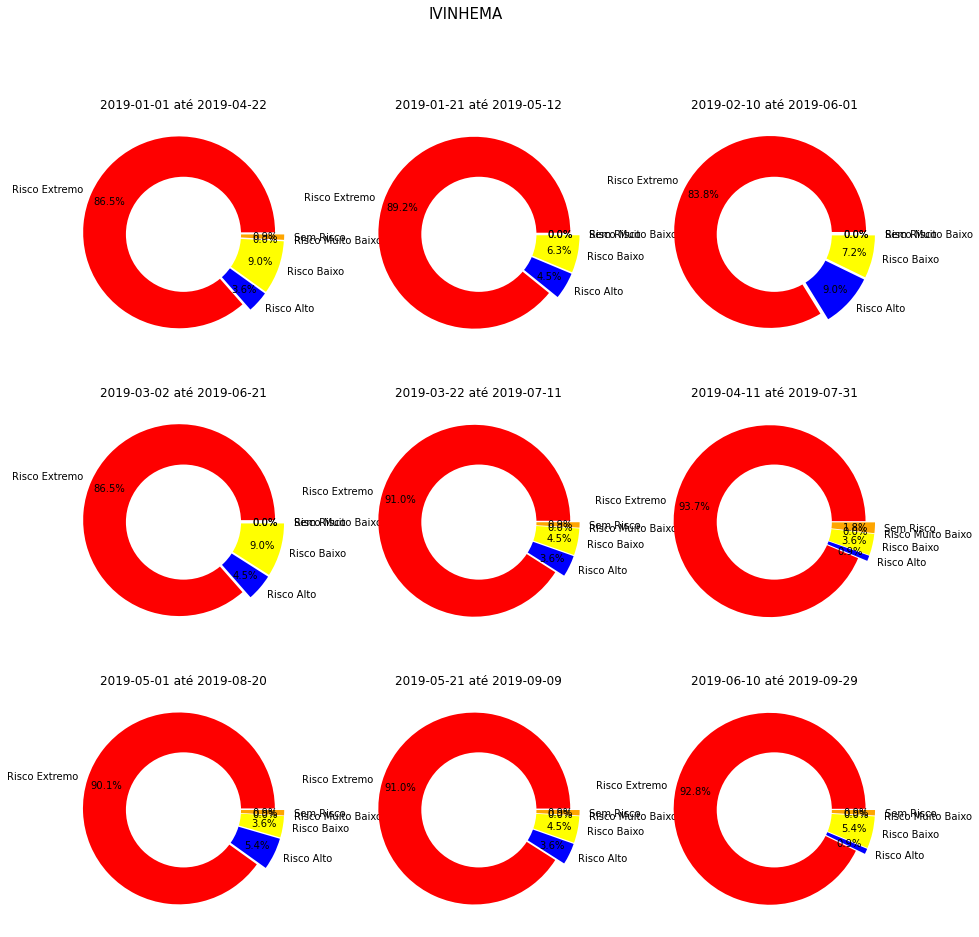

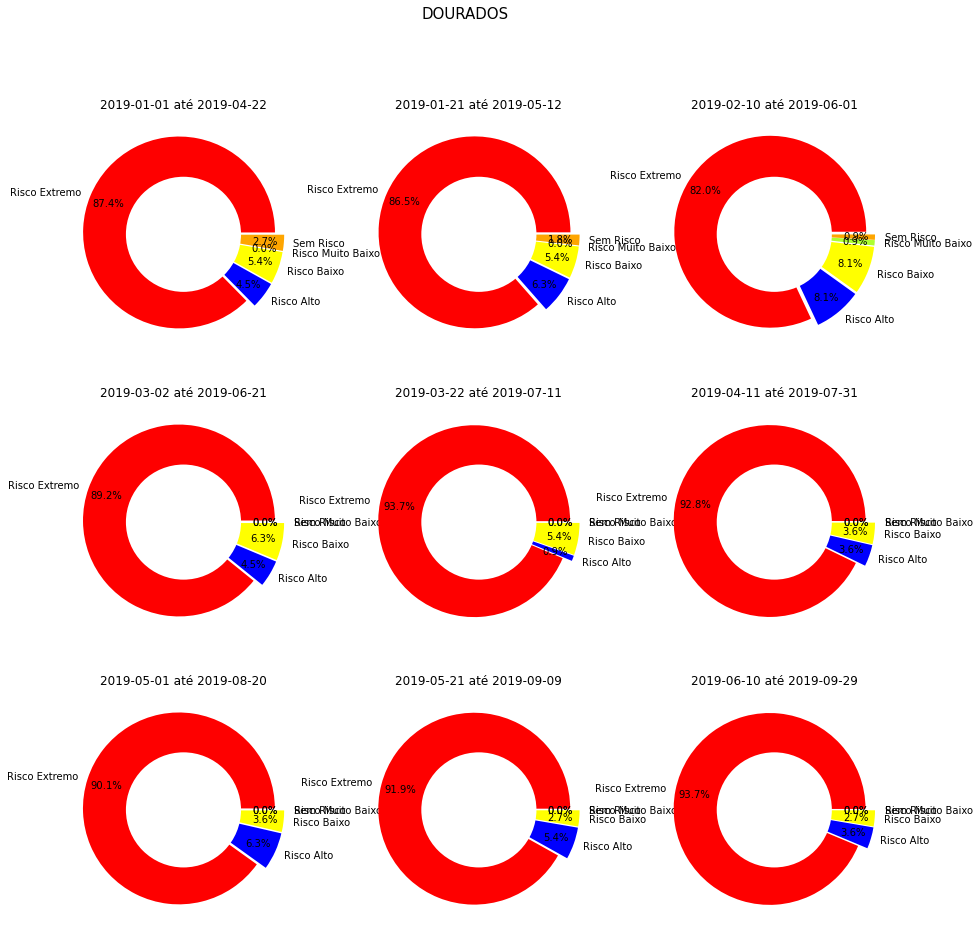

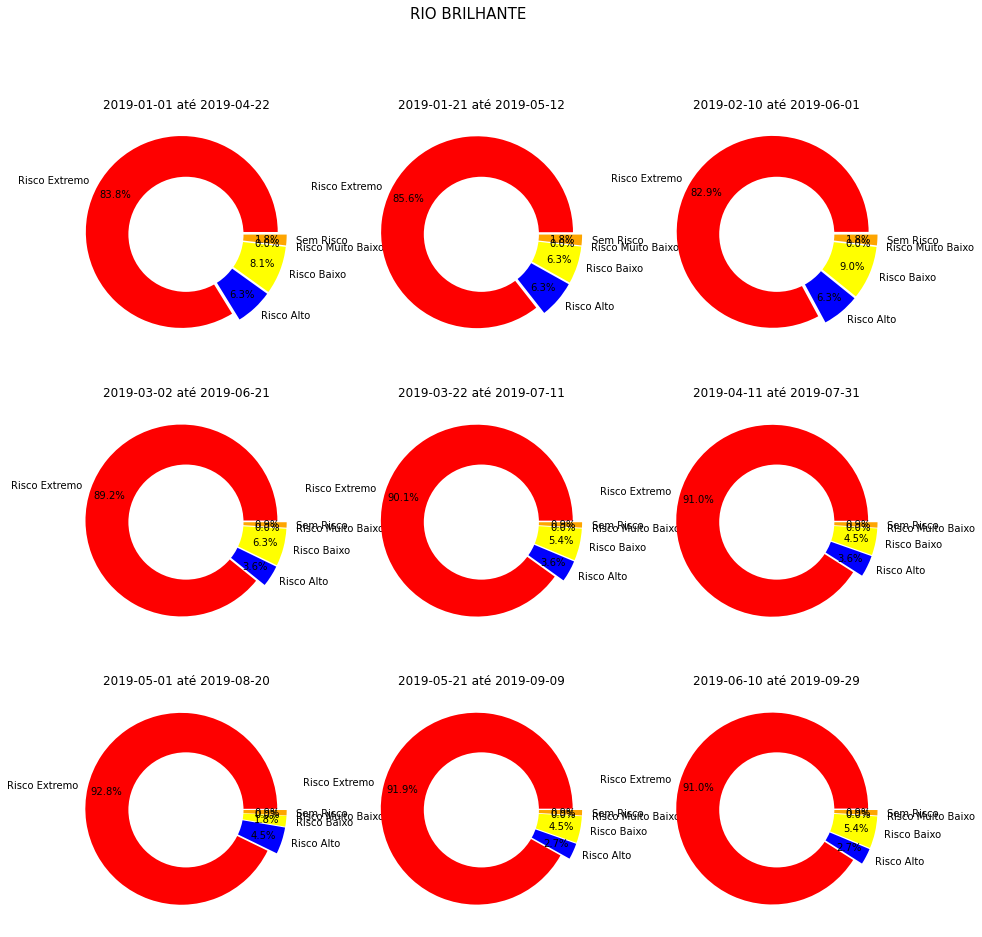

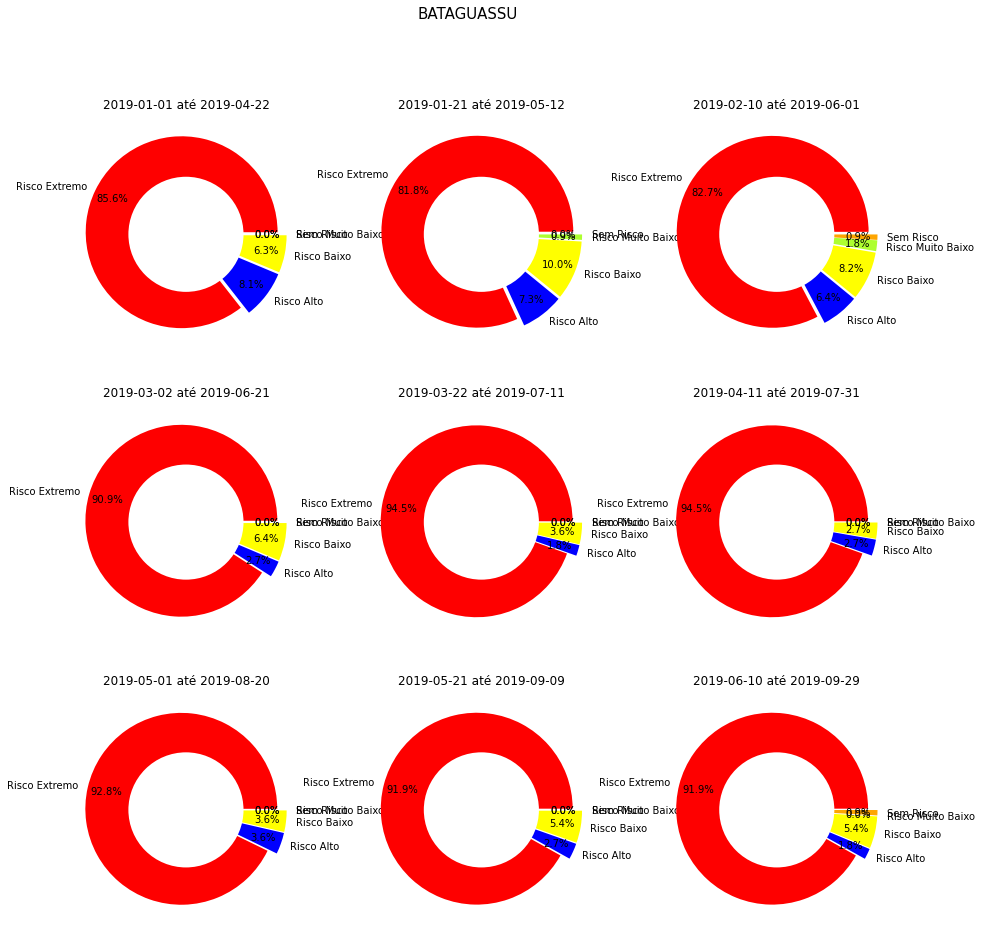

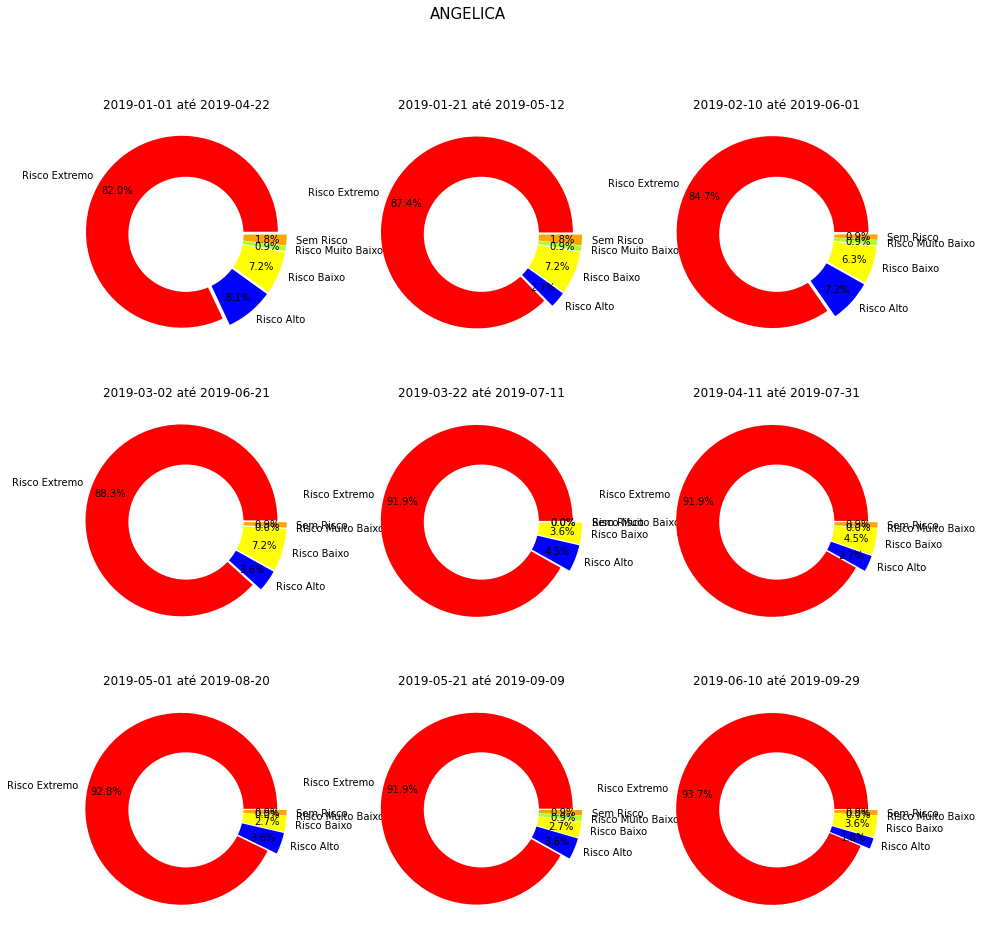

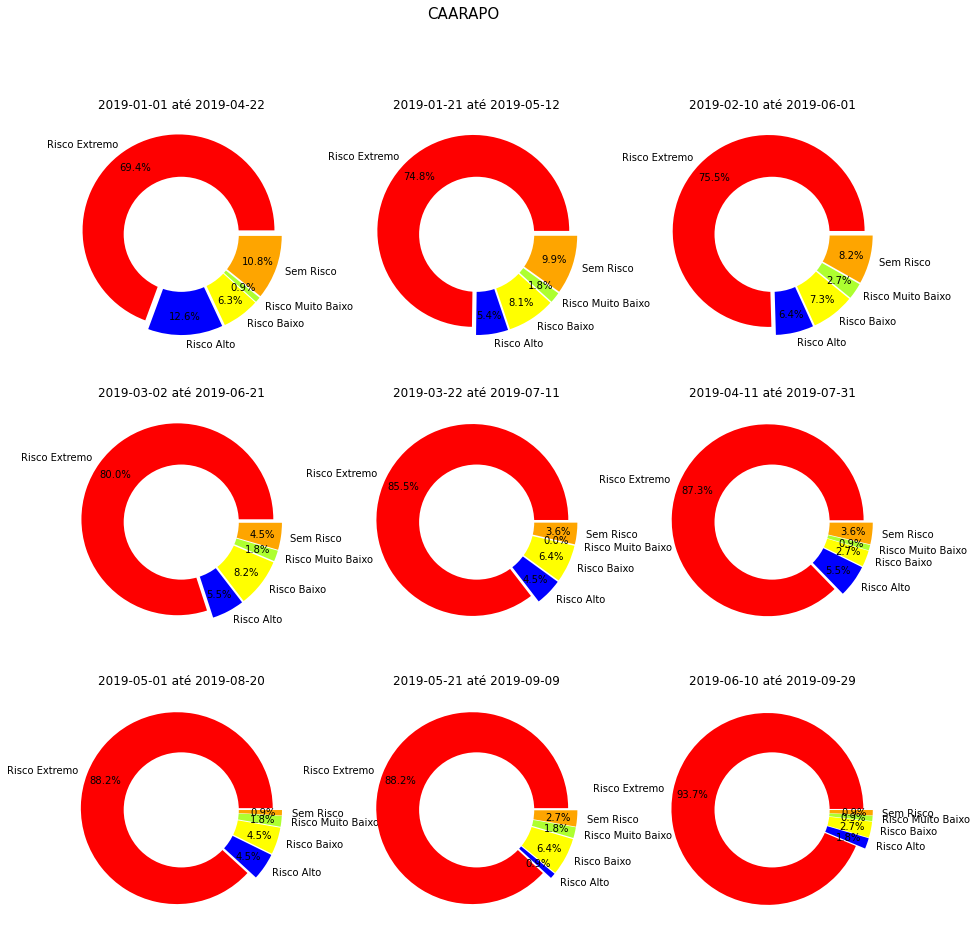

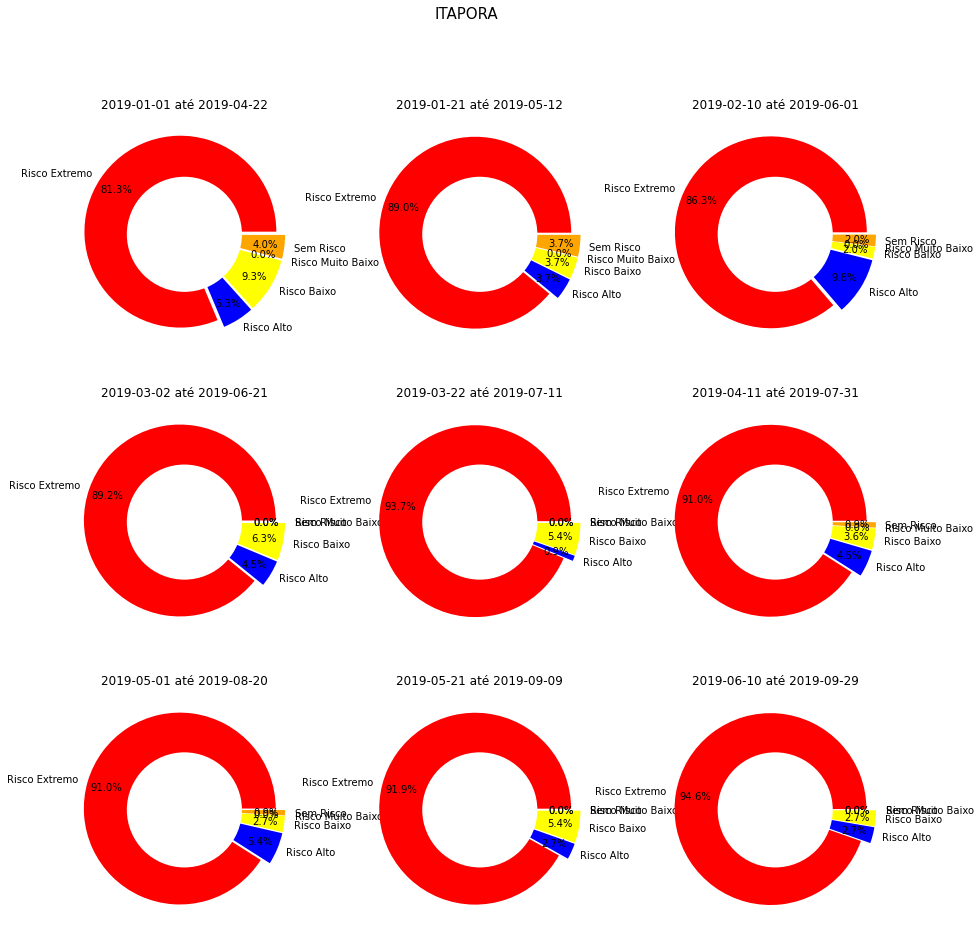

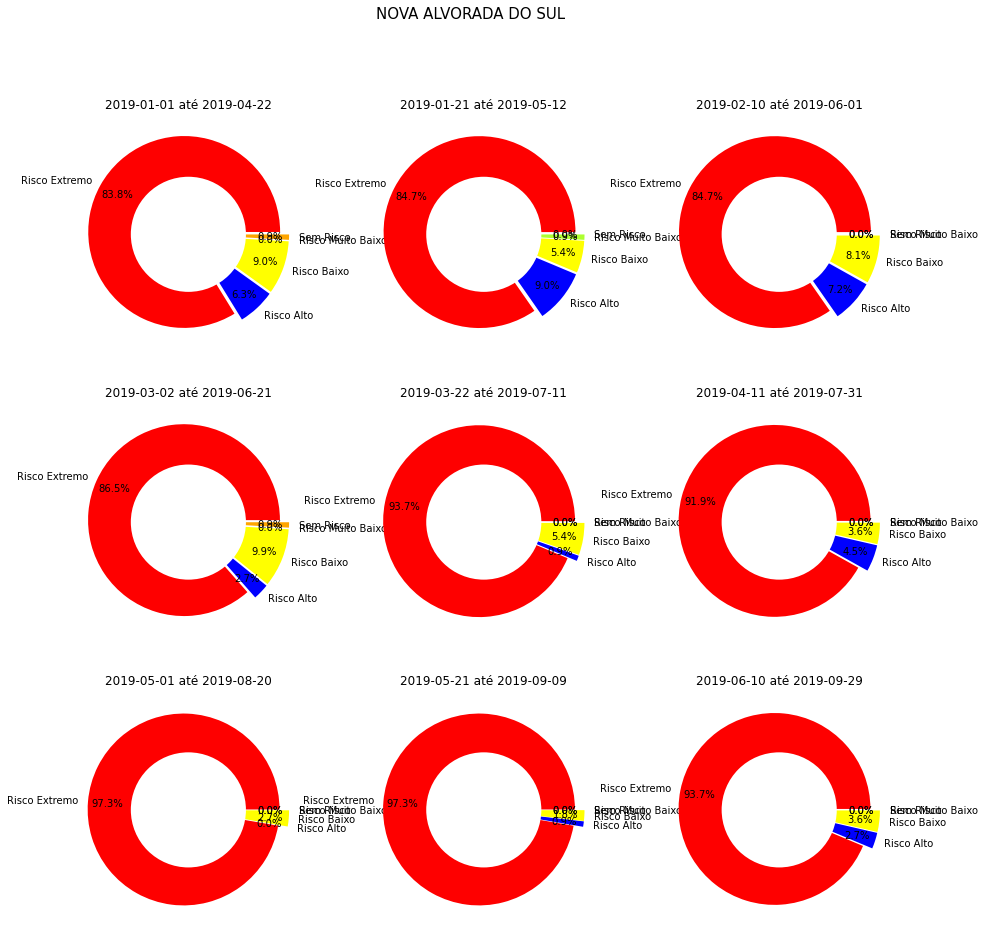

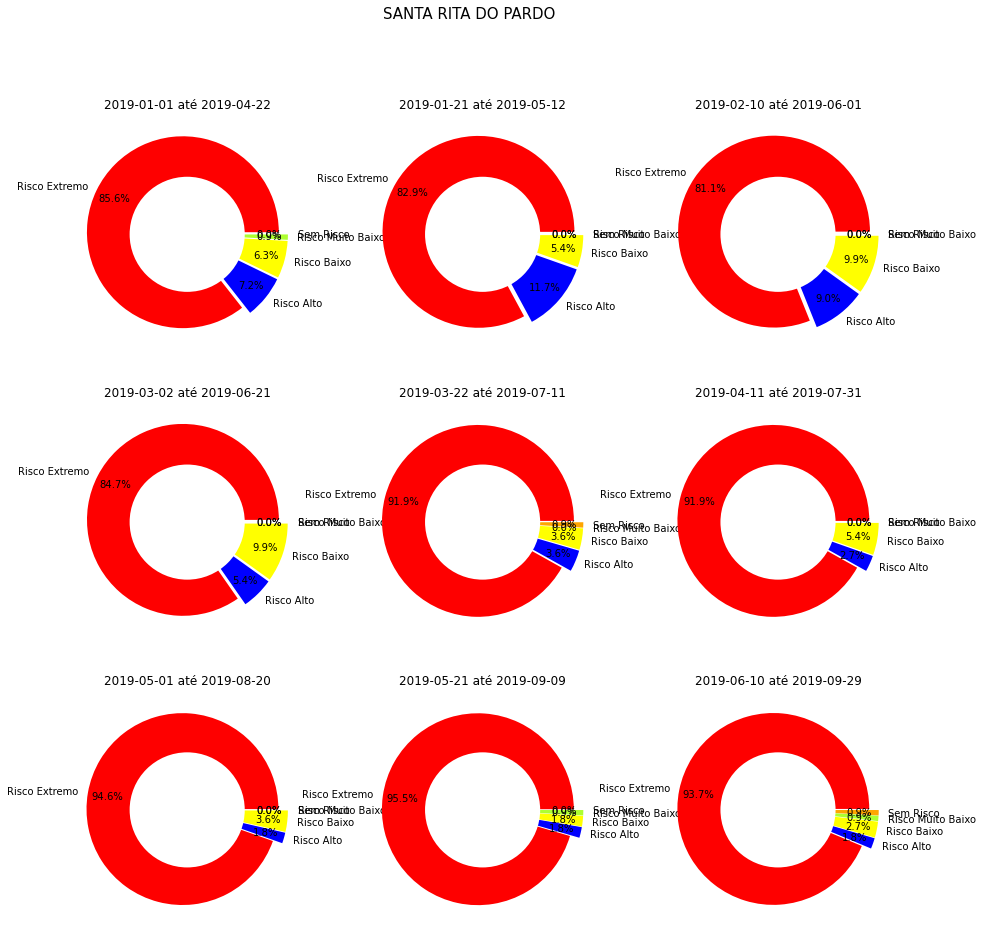

In [167]:
colors = ['#fe0000', '#0000fe', '#ffff00', '#adff30', '#fea500']
for j in range(9):
    fig, axs = plt.subplots(nrows=3, ncols=3)
    fig.set_size_inches(15, 15)
    for i, ax in enumerate(axs.reshape(-1)):
        ax.pie(isnas[j].iloc[:,i][:-1], labels=isnas[j].index[:-1], autopct='%1.1f%%', pctdistance=0.8, explode=[.05]*5, colors = colors)
        cc = plt.Circle((0, 0), 0.6, fc='white')
        ax.add_artist(cc)
        ax.title.set_text(isnas[0].columns[i])
    periodo = isnas[j].name
    fig.suptitle(periodo, fontsize=15)
    fig.savefig(f'datasets/isnas/{periodo}.png')

In [22]:
isnas[0].index

Index(['Risco Extremo', 'Risco Alto', 'Risco Baixo', 'Risco Muito Baixo',
       'Sem Risco', 'Erro'],
      dtype='object')